## 이 데이터는 얼마나 믿을 수 있을까?

In [66]:
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm 
import seaborn as sb
from math import sqrt
from hossam import load_data
import numpy as np
import pandas as pd
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import t, normaltest, bartlett, levene, f_oneway, ttest_ind, zscore, pearsonr, spearmanr, probplot, shapiro, anderson
from statsmodels.stats.anova import anova_lm 
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pingouin import anova, welch_anova
from statsmodels.sandbox.stats.multicomp import MultiComparison
from pandas import DataFrame, melt, CategoricalDtype
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from pingouin import pairwise_tukey, pairwise_tests, pairwise_gameshowell
import statsmodels.api as sm
from statsmodels.formula.api import ols
from itertools import combinations

In [67]:
my_dpi = 200
font_path = 'C:\\Users\\wodyd\\Documents\\카카오톡 받은 파일./MaruBuri-Regular.ttf'
fm.fontManager.addfont(font_path)
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()
my_font_name = 'MaruBuri'
my_theme = 'dark'
sb.set_theme(style = my_theme)

plt.rcParams['font.family'] = my_font_name
plt.rcParams['font.size'] = 10
plt.rcParams['axes.unicode_minus'] = False

In [68]:
origin = load_data('diamonds')
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")
print(origin.info())
origin.head()

[data] https://data.hossam.kr/data/kaggle/diamonds.xlsx
[desc] 다이아몬드를 커팅, 색상, 투명도, 가격 및 기타 속성 조사한 데이터 셋 (출처: https://www.kaggle.com/datasets/shivam2503/diamonds)

field    description
-------  -------------------------------------------------------------------
price    다이아몬드 가격 (USD, $326 ~ $18,823)
carat    중량 (0.2~5.01)
cut      컷 품질 (Fair, Good, Very Good, Premium, Ideal)
color    색상 등급 - J (worst) to D (best)
clarity  투명도 등급 (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
x        길이 mm (0~10.74)
y        너비 mm (0--58.9)
z        두께 mm (0--31.8)
depth    비율 정보 = z / mean(x, y) = 2 * z / (x + y) (43--79)
table    다이아몬드의 가장 넓은 지점에 비해 상단(테이블)의 너비 (43--95)

데이터셋 크기: (53940, 10)
열 개수: 10
행 개수: 53940
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   price    53940 non-null  int64  
 1   carat    53940 non-null  float64
 2   cut      53940 non

,price,carat,cut,color,clarity,x,y,z,depth,table
0,326,0.23,Ideal,E,SI2,3.95,3.98,2.43,61.5,55.0
1,326,0.21,Premium,E,SI1,3.89,3.84,2.31,59.8,61.0
2,327,0.23,Good,E,VS1,4.05,4.07,2.31,56.9,65.0
3,334,0.29,Premium,I,VS2,4.20,4.23,2.63,62.4,58.0
4,335,0.31,Good,J,SI2,4.34,4.35,2.75,63.3,58.0


In [4]:
# 결측치 존재하지 않음을 확인
origin.isna().sum()

price      0
carat      0
cut        0
color      0
clarity    0
x          0
y          0
z          0
depth      0
table      0
dtype: int64

In [5]:
# 하나라도 0인 값이 존재함을 확인
(origin[['x', 'y', 'z']] == 0).any()

x    True
y    True
z    True
dtype: bool

In [6]:
origin[['price','carat','x','y','z','depth','table']].describe().T

,count,mean,std,min,25%,50%,75%,max
price,53940.0,3932.799722,3989.439738,326.0,950.00,2401.00,5324.25,18823.00
carat,53940.0,0.797940,0.474011,0.2,0.40,0.70,1.04,5.01
x,53940.0,5.731157,1.121761,0.0,4.71,5.70,6.54,10.74
y,53940.0,5.734526,1.142135,0.0,4.72,5.71,6.54,58.90
z,53940.0,3.538734,0.705699,0.0,2.91,3.53,4.04,31.80
depth,53940.0,61.749405,1.432621,43.0,61.00,61.80,62.50,79.00
table,53940.0,57.457184,2.234491,43.0,56.00,57.00,59.00,95.00


In [7]:
df1 = origin.copy()
df1 = df1[(df1['x'] != 0) & (df1['y'] != 0) & (df1['z'] != 0)]
df1

,price,carat,cut,color,clarity,x,y,z,depth,table
0,326,0.23,Ideal,E,SI2,3.95,3.98,2.43,61.5,55.0
1,326,0.21,Premium,E,SI1,3.89,3.84,2.31,59.8,61.0
2,327,0.23,Good,E,VS1,4.05,4.07,2.31,56.9,65.0
3,334,0.29,Premium,I,VS2,4.20,4.23,2.63,62.4,58.0
4,335,0.31,Good,J,SI2,4.34,4.35,2.75,63.3,58.0
...,...,...,...,...,...,...,...,...,...,...
53935,2757,0.72,Ideal,D,SI1,5.75,5.76,3.50,60.8,57.0
53936,2757,0.72,Good,D,SI1,5.69,5.75,3.61,63.1,55.0
53937,2757,0.70,Very Good,D,SI1,5.66,5.68,3.56,62.8,60.0
53938,2757,0.86,Premium,H,SI2,6.15,6.12,3.74,61.0,58.0


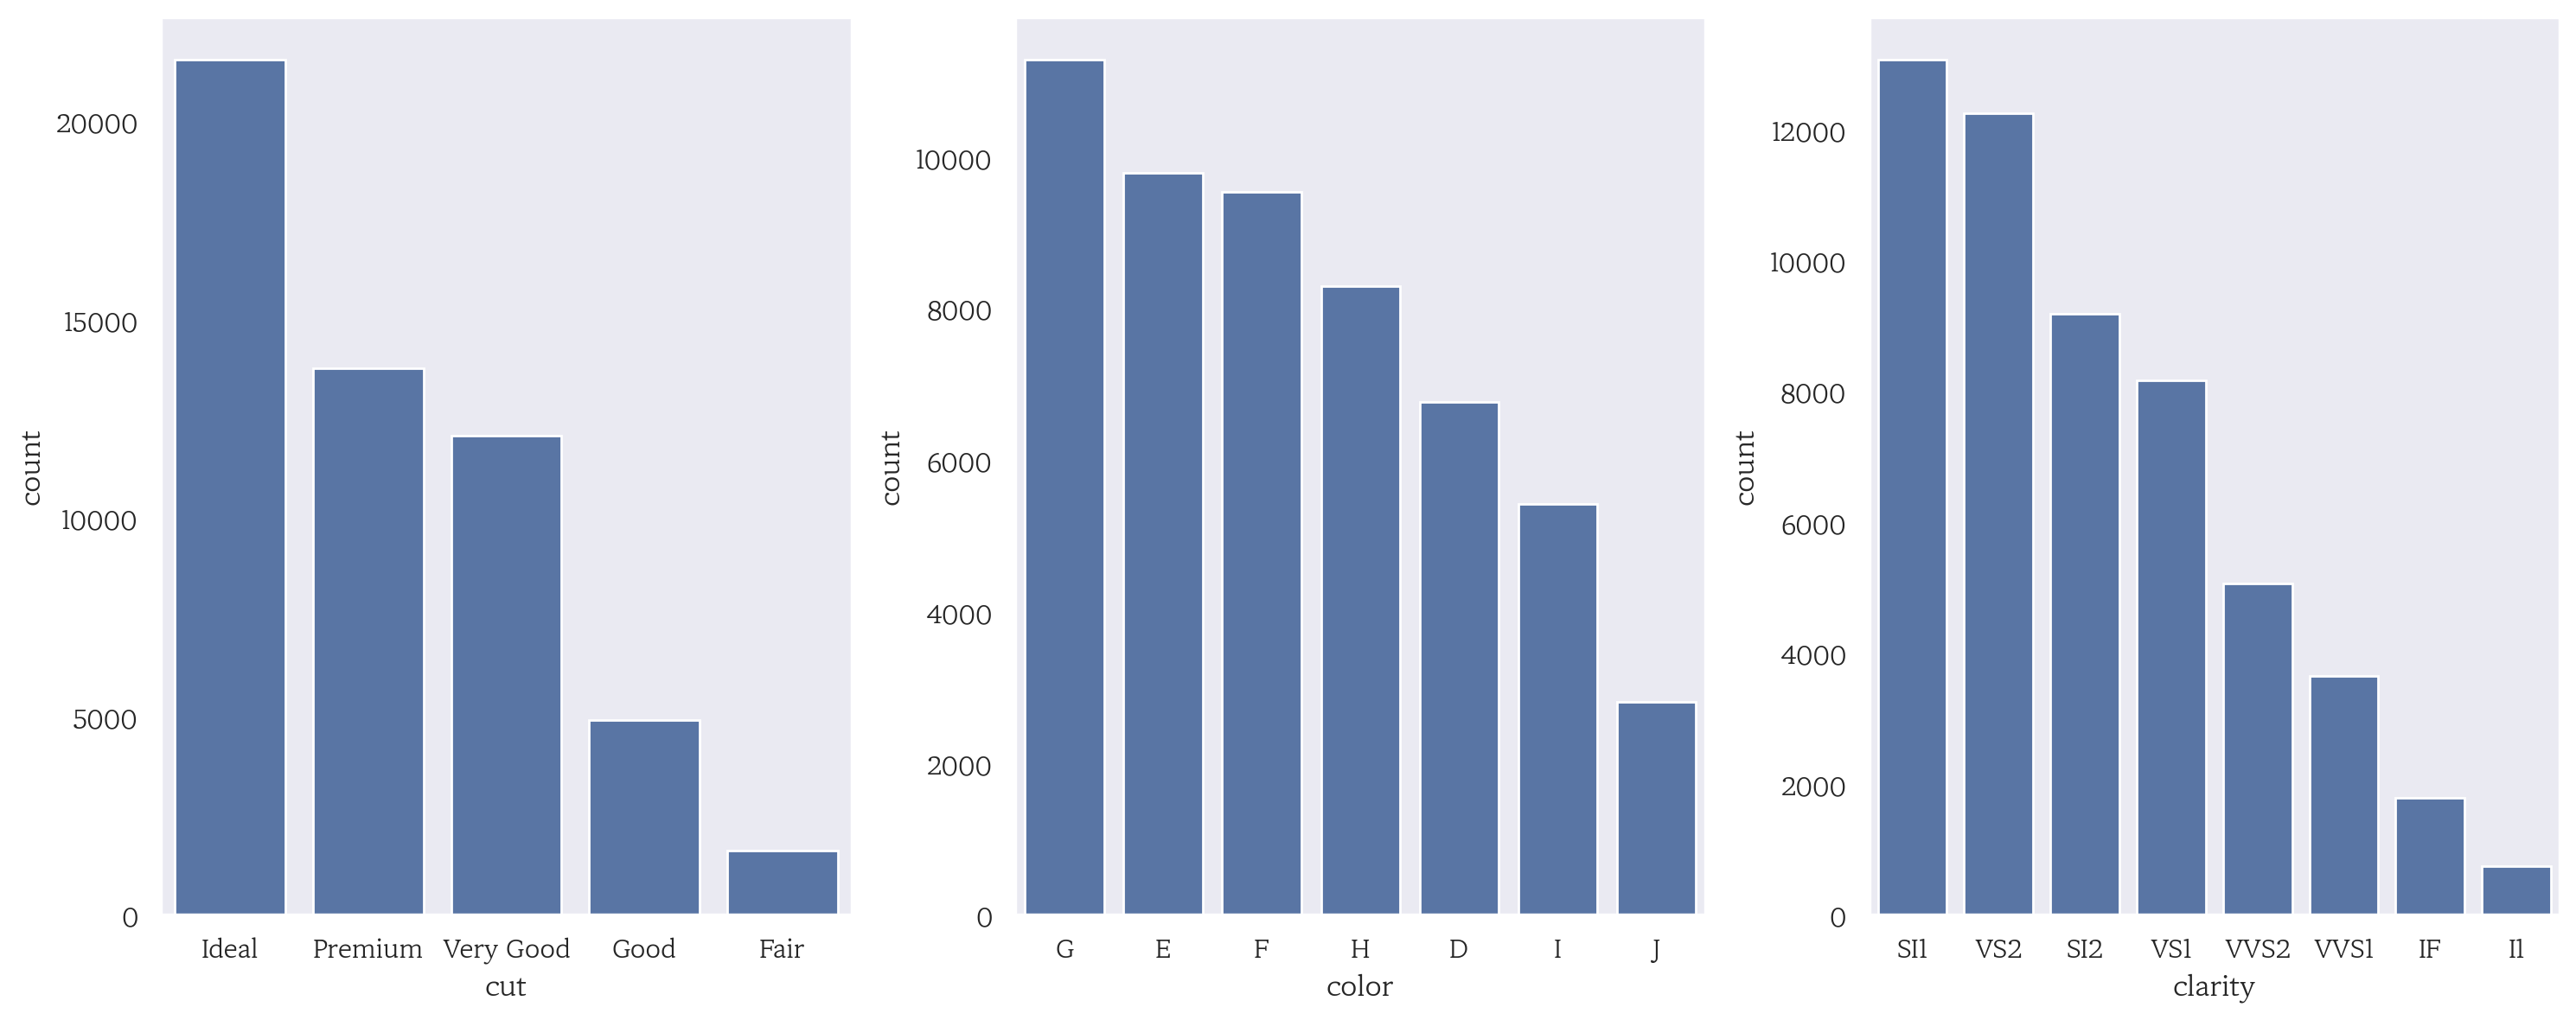

In [8]:
# plt.subplots(행,열,[figsize =(가로,세로)])
width_px = 3000
height_px = 1200
rows = 1                                                           #서브플롯 사용시 값 변경
cols = 3                                                           #서브플롯 사용시 값 변경
figsize = (width_px/ my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)


order = df1['cut'].value_counts().sort_values(ascending = False).index
order_color = df1['color'].value_counts().sort_values(ascending = False).index
order_clarity = df1['clarity'].value_counts().sort_values(ascending = False).index
sb.countplot(data=df1, x = 'cut', order = order,ax=ax[0])
sb.countplot(data=df1, x = 'color', order = order_color,ax=ax[1])
sb.countplot(data=df1, x = 'clarity', order = order_clarity, ax=ax[2])

fig.subplots_adjust(wspace = 0.2, hspace = 0.2)

# 출력
plt.tight_layout()
plt.show()
plt.close()


### 인사이트

- cut: Ideal에 값이 치중되어 있다.

- 결측치 존재여부 판단 후, x,y,z값 중 0이 존재하는 행(20개)을 삭제하였다. 

- 그 이유는, 결측치가 있는 데이터의 수가 극소수였기 때문이다.

## 미션 2
### price 변수 분포

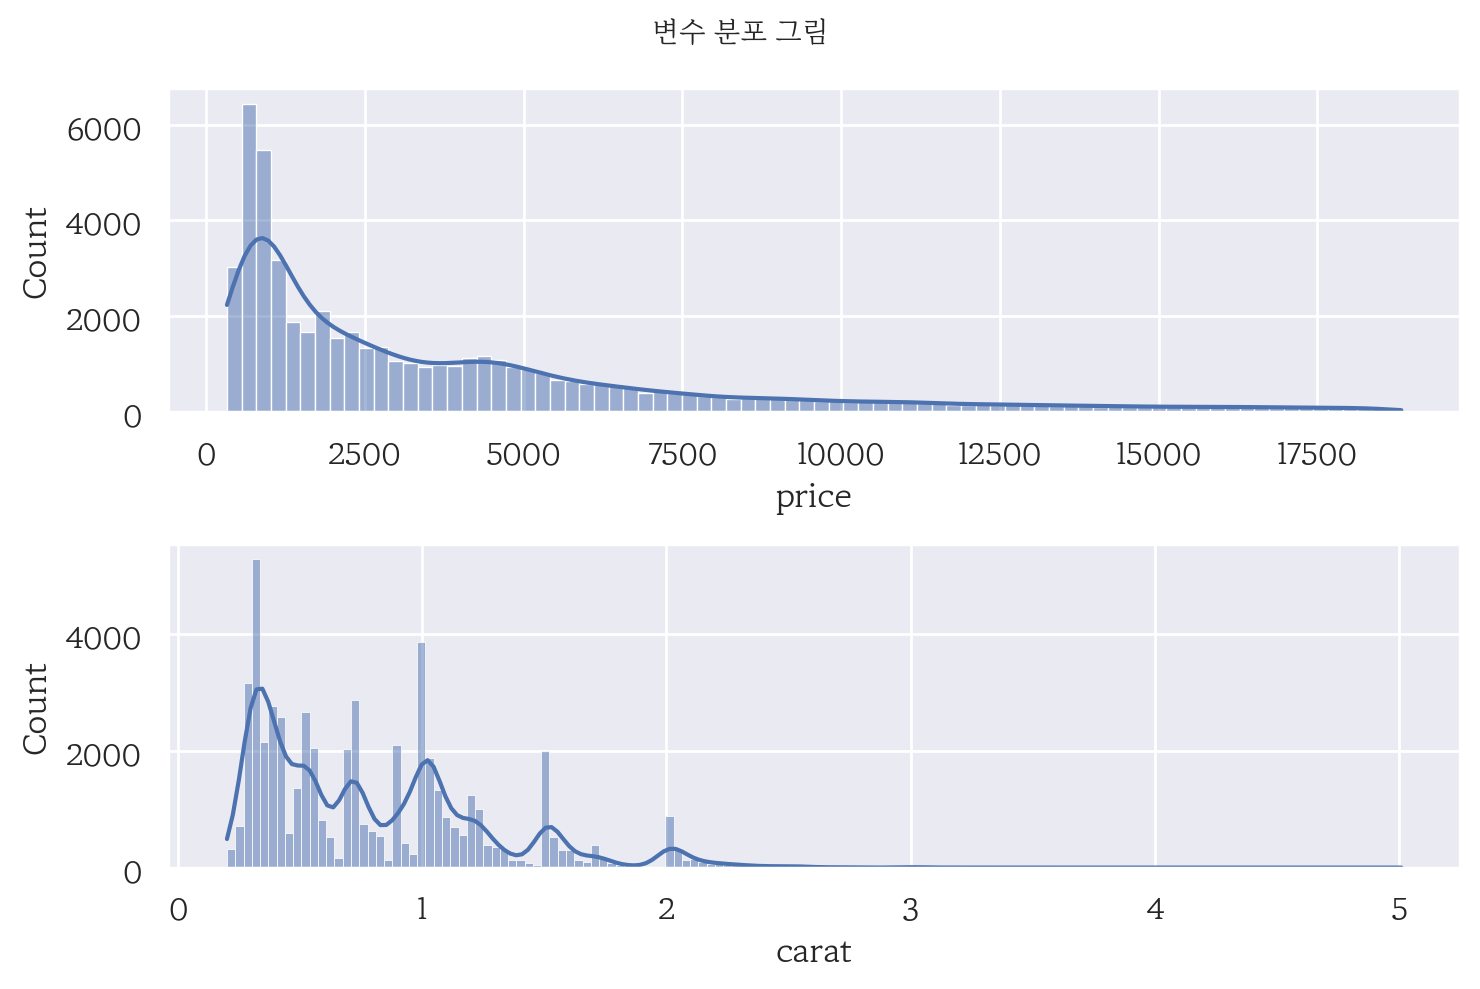

In [9]:
width_px = 1500
height_px = 1000
rows = 2
cols = 1
figsize = (width_px/ my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# histplot 그리기 
sb.histplot(data =df1, x = 'price', kde = True, alpha = 0.5, ax=ax[0])
sb.histplot(data = df1, x='carat', kde = True, alpha = 0.5, ax=ax[1])

# 그래프 꾸미기
ax[0].grid(True)
ax[1].grid(True) # 배경 격자 표시/숨김
fig.suptitle("변수 분포 그림", fontsize=10)


# 출력
plt.tight_layout()
plt.savefig('myplot.png', dpi = my_dpi)
plt.show()
plt.close()

- price 데이터의 경우, 0~2500 사이에 값들이 밀집되어있는 것으로 확인된다(우편향 그래프)
- carat 데이터의 경우, 0~1 사이에 데이터가 밀집되어 있는것으로 확인된다(우편향 그래프)

### 인사이트
- 바로 회귀분석을 수행하면 안된다. 정규성, 등분산성을 만족하지 못하였기 때문이다

## 미션 3

### Price 값에 대한 로그변환 후, 전

In [10]:
log_data = np.log(origin['price'])
log_data
target_value = np.log(10)

In [11]:
s, p = normaltest(origin['price'])  
'statistic: {0:.3f}, p-value: {1:.3f}, 정규성 충족 여부: {2}'.format(s, p, p > 0.05)

'statistic: 15096.650, p-value: 0.000, 정규성 충족 여부: False'

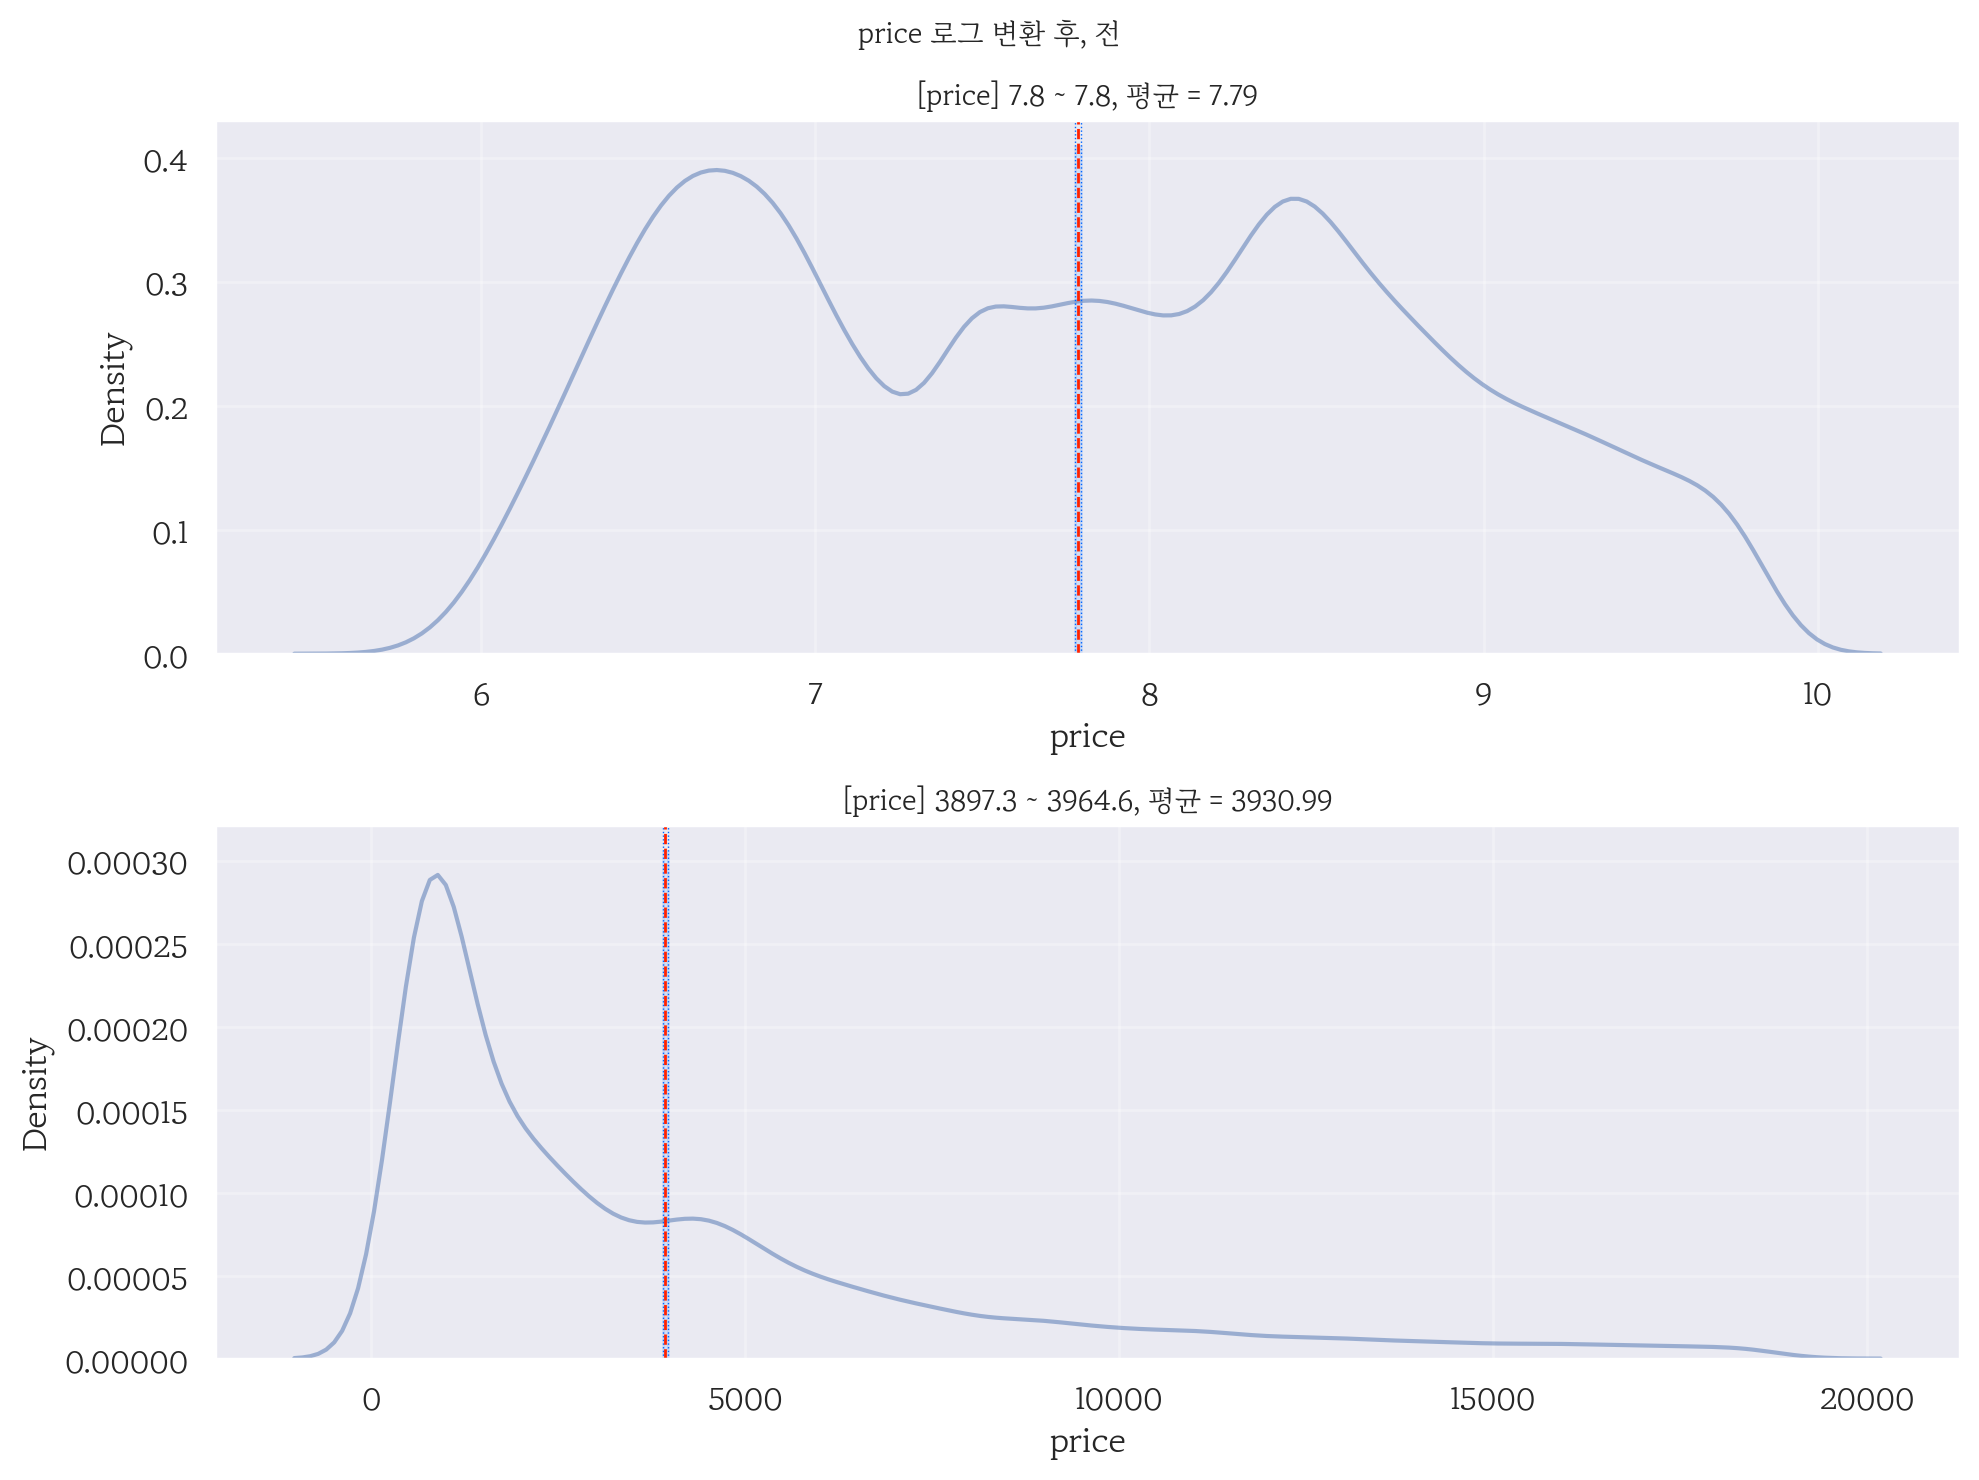

In [12]:
data = log_data
max1 = data.max()
clevel = 0.95
dof1 = len(data) - 1
sp_mean1 = data.mean()
sp_std1 = data.std(ddof=1)
sp_std_error1 = sp_std1 / sqrt(len(data))
cmin1, cmax1 = t.interval(clevel, dof1, loc=sp_mean1, scale=sp_std_error1)

# 두 번째 데이터 통계
data2 = df1['price']
max2 = data2.max()
dof2 = len(data2) - 1
sp_mean2 = data2.mean()
sp_std2 = data2.std(ddof=1)
sp_std_error2 = sp_std2 / sqrt(len(data2))         
cmin2, cmax2 = t.interval(clevel, dof2, loc=sp_mean2, scale=sp_std_error2)  

width_px = 2000
height_px = 1500
rows = 2
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# kdeplot
sb.kdeplot(data=data, fill=False, alpha=0.5, ax=ax[0])      # palette는 여기서 의미 없음(단일)
sb.kdeplot(data=df1, x='price', alpha=0.5, ax=ax[1])

fig.suptitle("price 로그 변환 후, 전", fontsize=10)

# 신뢰구간 라인
ax[0].axvline(cmin1, linestyle=':', color='#0066ff', linewidth=0.5)
ax[0].axvline(cmax1, linestyle=':', color='#0066ff', linewidth=0.5)
ax[1].axvline(cmin2, linestyle=':', color='#0066ff', linewidth=0.5)
ax[1].axvline(cmax2, linestyle=':', color='#0066ff', linewidth=0.5)

# ylim 가져오기
ymin1, ymax1 = ax[0].get_ylim()
ymin2, ymax2 = ax[1].get_ylim()

# 신뢰구간 음영
ax[0].fill_between([cmin1, cmax1], 0, ymax1, alpha=0.1, color='#0066ff88')
ax[1].fill_between([cmin2, cmax2], 0, ymax2, alpha=0.1, color='#0066ff88')  

# 평균선
ax[0].axvline(sp_mean1, linestyle='--', linewidth=1, color='#ff2200')
ax[1].axvline(sp_mean2, linestyle='--', linewidth=1, color='#ff2200')       

# grid + title
ax[0].grid(True, alpha=0.3)
ax[1].grid(True, alpha=0.3)

ax[0].set_title(f'[{data.name}] {cmin1:.1f} ~ {cmax1:.1f}, 평균 = {sp_mean1:0.2f}', fontsize=10)
ax[1].set_title(f'[price] {cmin2:.1f} ~ {cmax2:.1f}, 평균 = {sp_mean2:0.2f}', fontsize=10)  

plt.tight_layout()
plt.show()
plt.close()

### carat값에 대한 로그변환 후, 전

In [13]:
log_data2 = np.log(origin['carat'])
log_data2
target_value = np.log(10)

In [14]:
s, p = normaltest(origin['carat'])  
'statistic: {0:.3f}, p-value: {1:.3f}, 정규성 충족 여부: {2}'.format(s, p, p > 0.05)

'statistic: 8926.738, p-value: 0.000, 정규성 충족 여부: False'

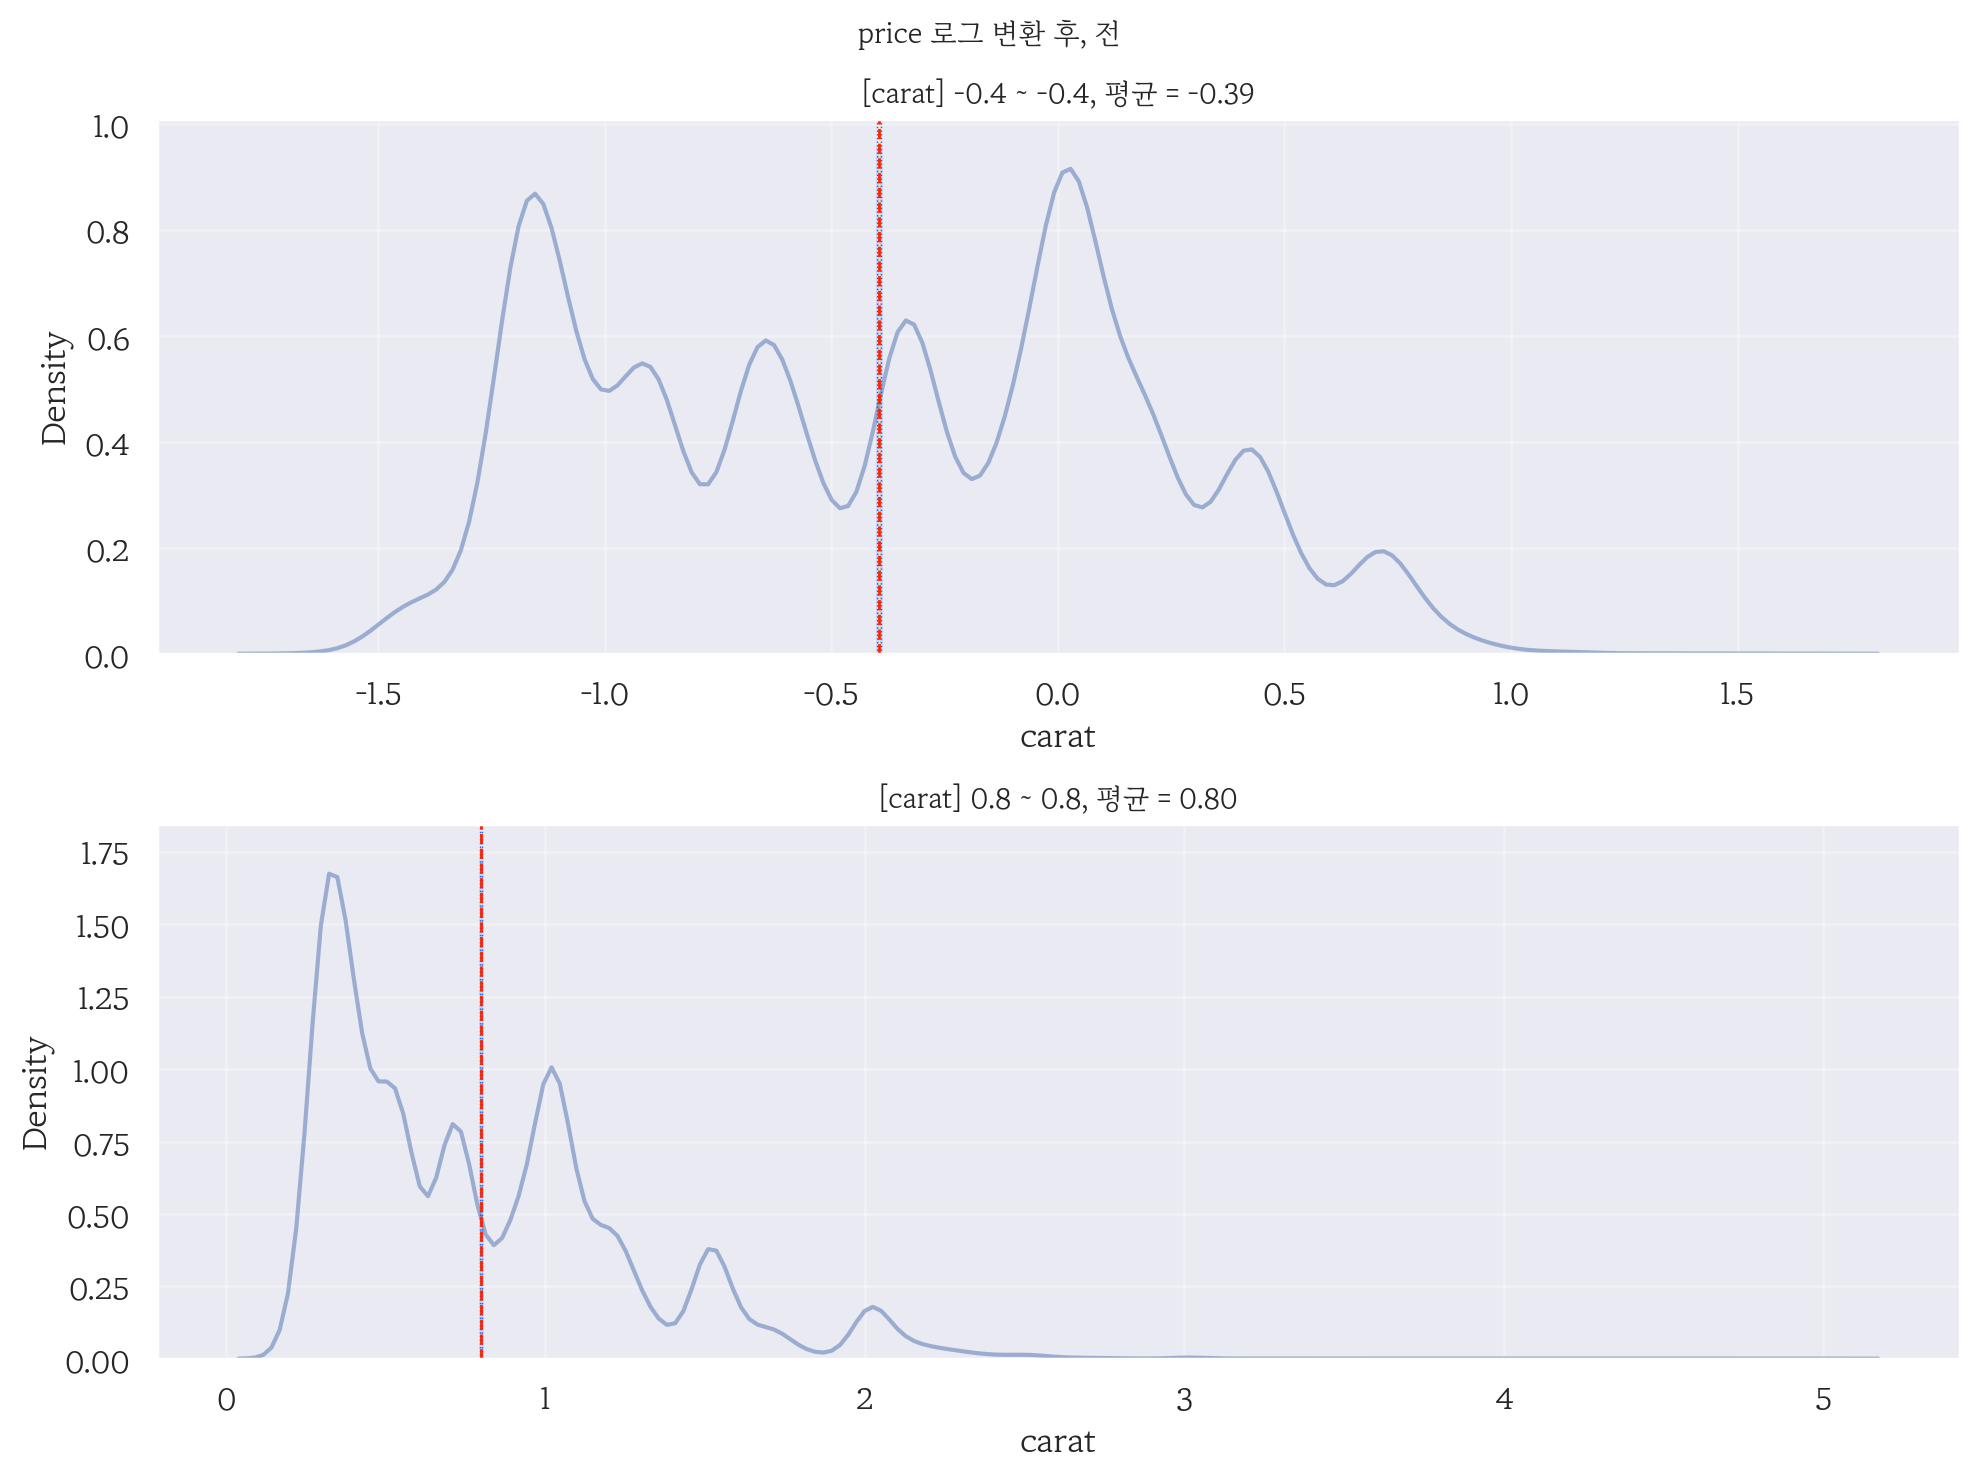

In [15]:
data = log_data2
max1 = data.max()
clevel = 0.95
dof1 = len(data) - 1
sp_mean1 = data.mean()
sp_std1 = data.std(ddof=1)
sp_std_error1 = sp_std1 / sqrt(len(data))
cmin1, cmax1 = t.interval(clevel, dof1, loc=sp_mean1, scale=sp_std_error1)

# 두 번째 데이터 통계
data2 = df1['carat']
max2 = data2.max()
clevel = 0.95
dof2 = len(data2) - 1
sp_mean2 = data2.mean()
sp_std2 = data2.std(ddof=1)
sp_std_error2 = sp_std2 / sqrt(len(data2))          
cmin2, cmax2 = t.interval(clevel, dof2, loc=sp_mean2, scale=sp_std_error2)  

width_px = 2000
height_px = 1500
rows = 2
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# kdeplot
sb.kdeplot(data=data, fill=False, alpha=0.5, ax=ax[0])      # palette는 여기서 의미 없음(단일)
sb.kdeplot(data=df1, x='carat', alpha=0.5, ax=ax[1])

fig.suptitle("price 로그 변환 후, 전", fontsize=10)

# 신뢰구간 라인
ax[0].axvline(cmin1, linestyle=':', color='#0066ff', linewidth=0.5)
ax[0].axvline(cmax1, linestyle=':', color='#0066ff', linewidth=0.5)
ax[1].axvline(cmin2, linestyle=':', color='#0066ff', linewidth=0.5)
ax[1].axvline(cmax2, linestyle=':', color='#0066ff', linewidth=0.5)

# ylim 가져오기
ymin1, ymax1 = ax[0].get_ylim()
ymin2, ymax2 = ax[1].get_ylim()

# 신뢰구간 음영
ax[0].fill_between([cmin1, cmax1], 0, ymax1, alpha=0.1, color='#0066ff88')
ax[1].fill_between([cmin2, cmax2], 0, ymax2, alpha=0.1, color='#0066ff88')  # ✅ 수정

# 평균선
ax[0].axvline(sp_mean1, linestyle='--', linewidth=1, color='#ff2200')
ax[1].axvline(sp_mean2, linestyle='--', linewidth=1, color='#ff2200')       # ✅ 수정

# grid + title
ax[0].grid(True, alpha=0.3)
ax[1].grid(True, alpha=0.3)

ax[0].set_title(f'[{data.name}] {cmin1:.1f} ~ {cmax1:.1f}, 평균 = {sp_mean1:0.2f}', fontsize=10)
ax[1].set_title(f'[carat] {cmin2:.1f} ~ {cmax2:.1f}, 평균 = {sp_mean2:0.2f}', fontsize=10)  # ✅ 수정

plt.tight_layout()
plt.show()
plt.close()

#### 인사이트
- price, carat 데이터 모두 로그 변환전, 정규성을 충족하지 않는다.

- 로그 변환은 price와 carat의 분포가 한쪽으로 치우쳐 있는 문제를 완화하고, 

- 그 결과 회귀모형의 잔차가 정규성 가정에 더 가까워질 수 있도록 하기 위해 사용하였다.

## 미션 4

In [16]:
df2 = df1.copy()
df2 = df2.astype({'cut':'category','color':'category','clarity':'category'})
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53920 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   price    53920 non-null  int64   
 1   carat    53920 non-null  float64 
 2   cut      53920 non-null  category
 3   color    53920 non-null  category
 4   clarity  53920 non-null  category
 5   x        53920 non-null  float64 
 6   y        53920 non-null  float64 
 7   z        53920 non-null  float64 
 8   depth    53920 non-null  float64 
 9   table    53920 non-null  float64 
dtypes: category(3), float64(6), int64(1)
memory usage: 3.4 MB


In [17]:
df3 = df2.copy()
df3['cut'] = df3['cut'].astype(
    CategoricalDtype(categories=['Fair','Good','Very Good','Premium','Ideal'], ordered = True)
)
df3['color'] = df3['color'].astype(
    CategoricalDtype(categories=['J','I','H','G','F','E','D'], ordered = True)
)
df3['clarity'] = df3['clarity'].astype(
    CategoricalDtype(categories=['I1','SI2','SI1','VS2','VS1','VVS2','VVS1','IF'], ordered = True)
)

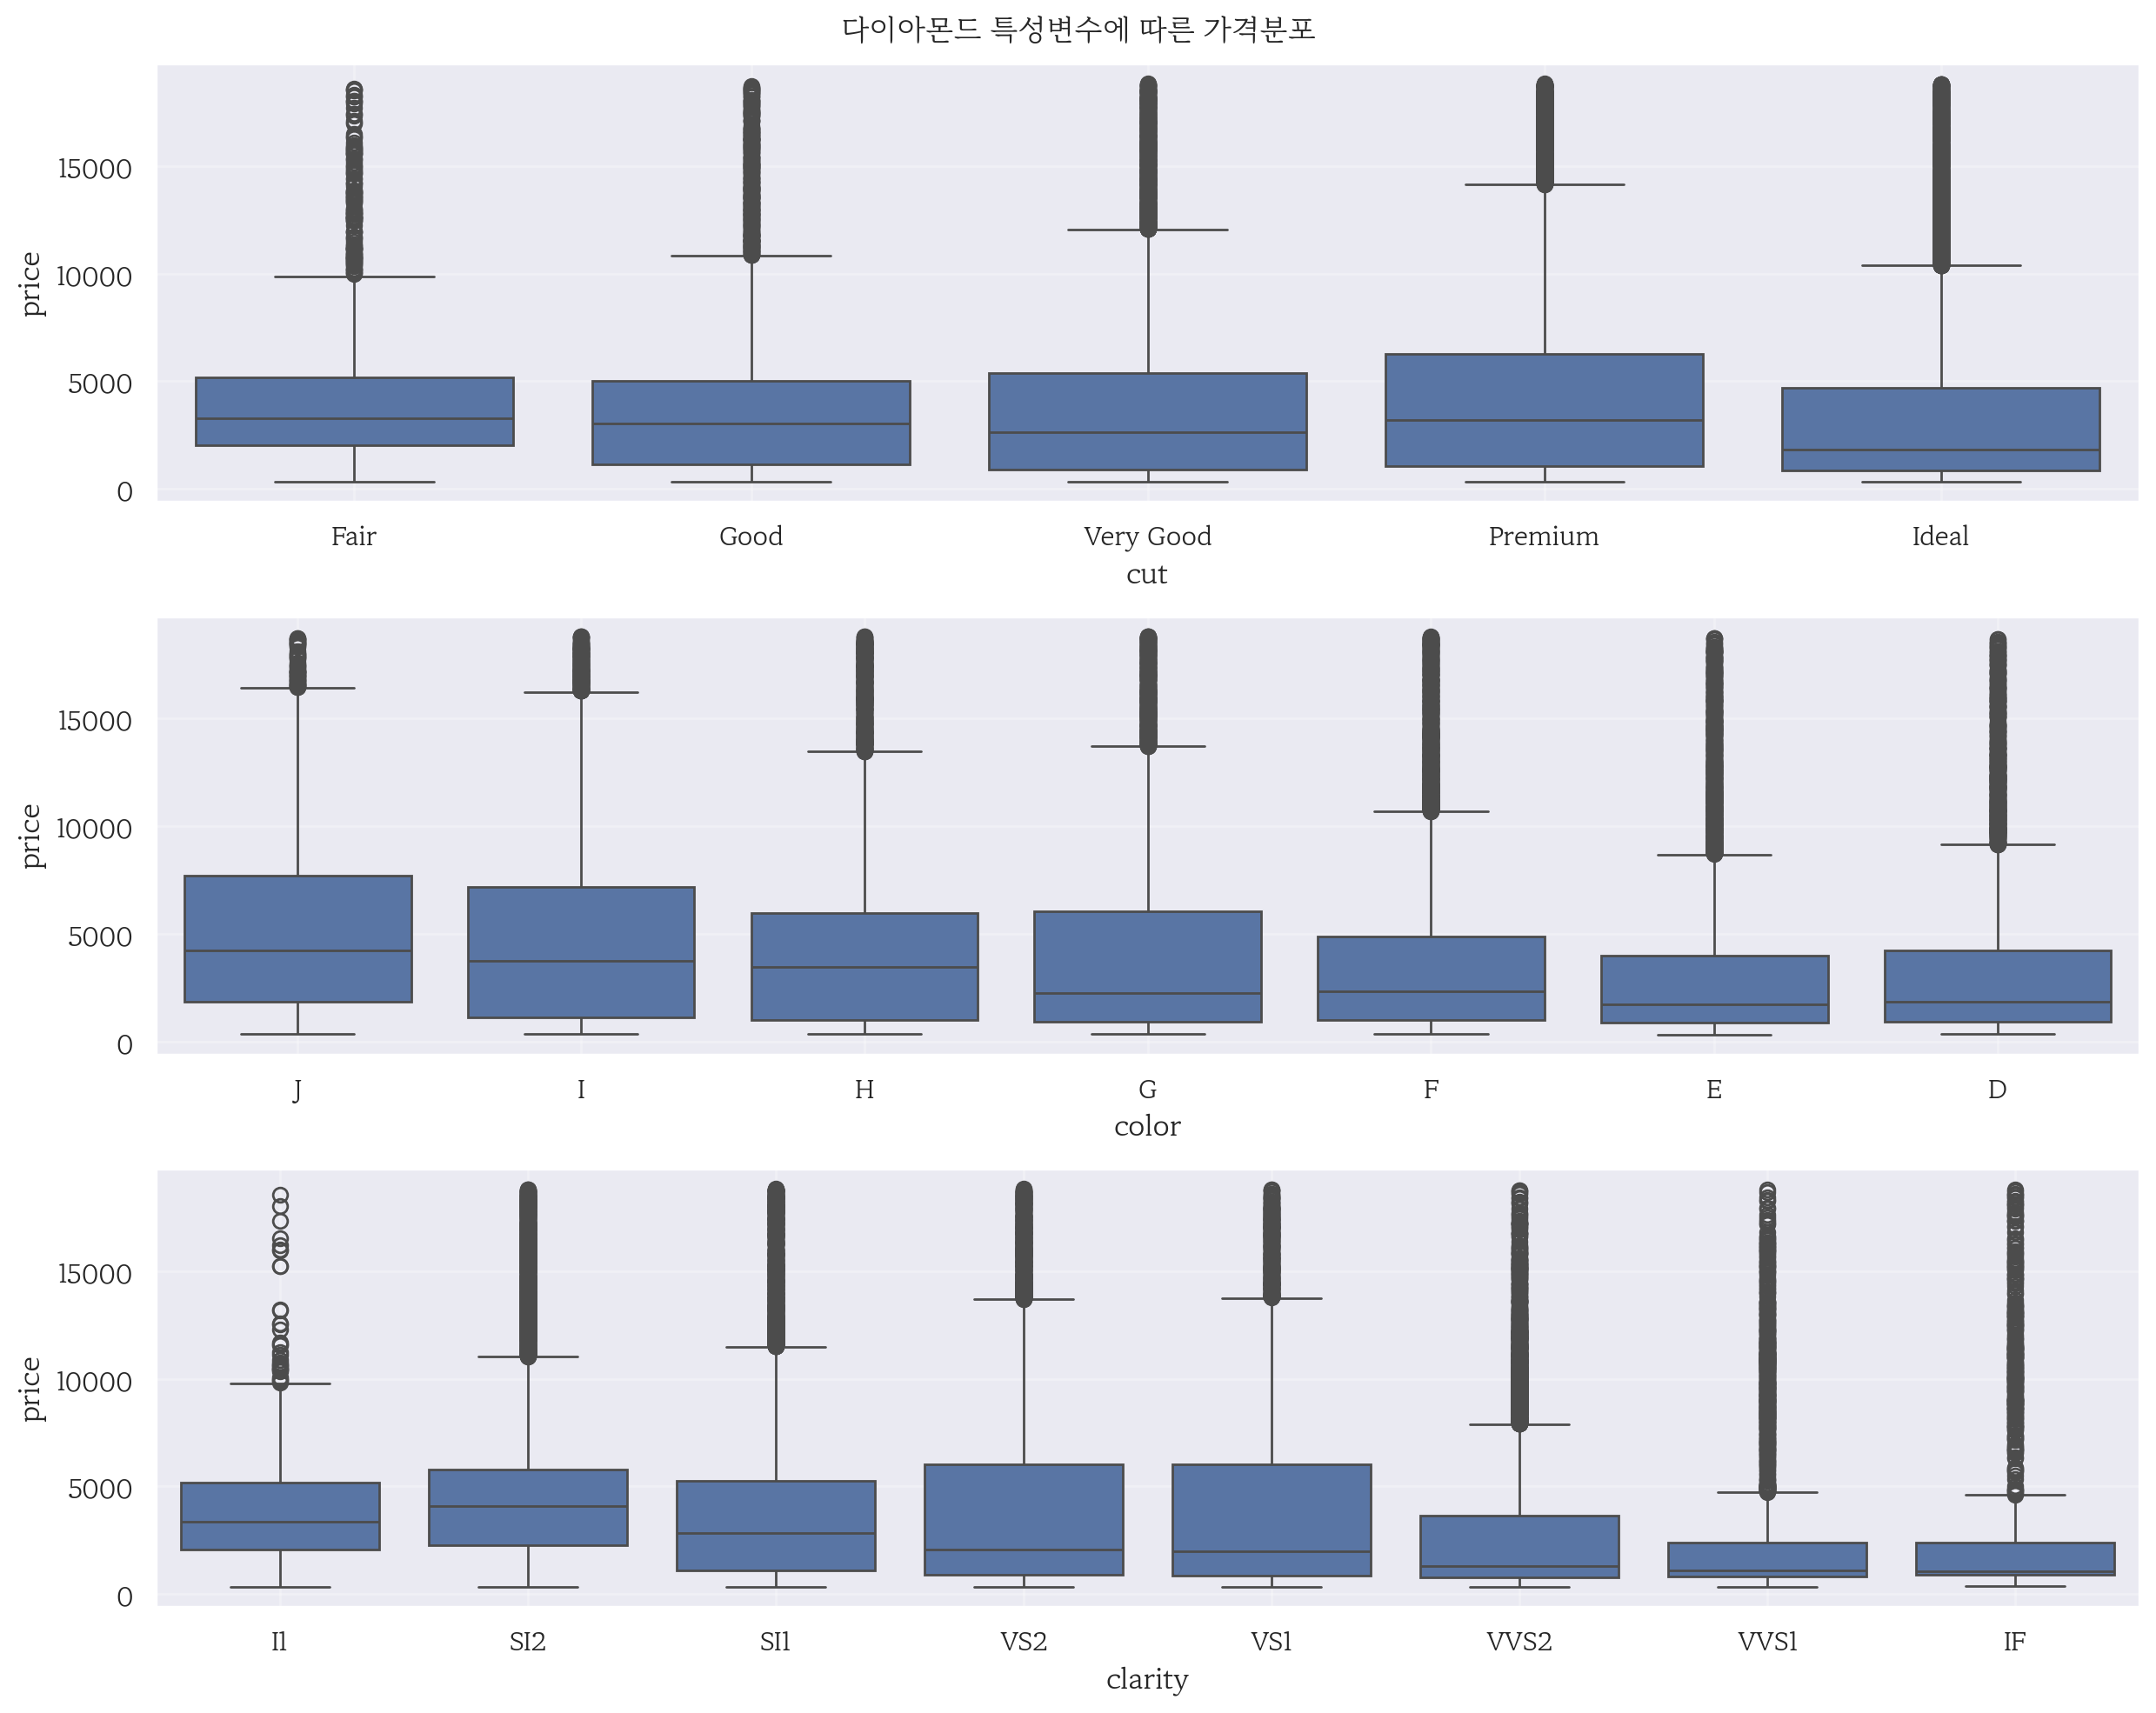

In [18]:
width_px = 2500
height_px = 2000
rows = 3
cols = 1
figsize = (width_px/ my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# box 그리기
sb.boxplot(data=df3, x='cut', y='price', ax=ax[0])
sb.boxplot(data=df3, x='color', y='price',ax=ax[1])
sb.boxplot(data=df3, x='clarity', y='price',ax=ax[2])

# 그래프 꾸미기
ax[0].grid(True, alpha = 0.3) # 배경 격자 표시/숨김
ax[1].grid(True, alpha = 0.3)
ax[2].grid(True, alpha = 0.3)

fig.suptitle('다이아몬드 특성변수에 따른 가격분포')
# 출력
plt.tight_layout()
plt.savefig('myplot.png', dpi = my_dpi)
plt.show()
plt.close()

### 인사이트
-   cut, color, clarity 모두에서 가격 분포의 중앙값과 변동 폭에 차이가 관찰된다.

    하지만 color와 clarity의 경우 등급이 높아질수록 중앙값이 뚜렷하게 분리되기보다는

    인접한 등급 간 가격 분포가 넓게 겹치는 양상을 보인다.

-   또한 각 등급 내 가격 분산이 비교적 크게 나타나며,

    해당 품질 요인(cut, color, clarity)만으로는 가격 수준을 명확히 구분하기에는 한계가 있음을 시사한다.
    
-   데이터의 실제 관계를 확인하기위해, 3개의 데이터가 우편향 현상을 나타내어도 로그변환을 취하지 않았다.

## 미션 5

### 정규성 확인
- 오른쪽으로 편향된 그래프가 형성된다

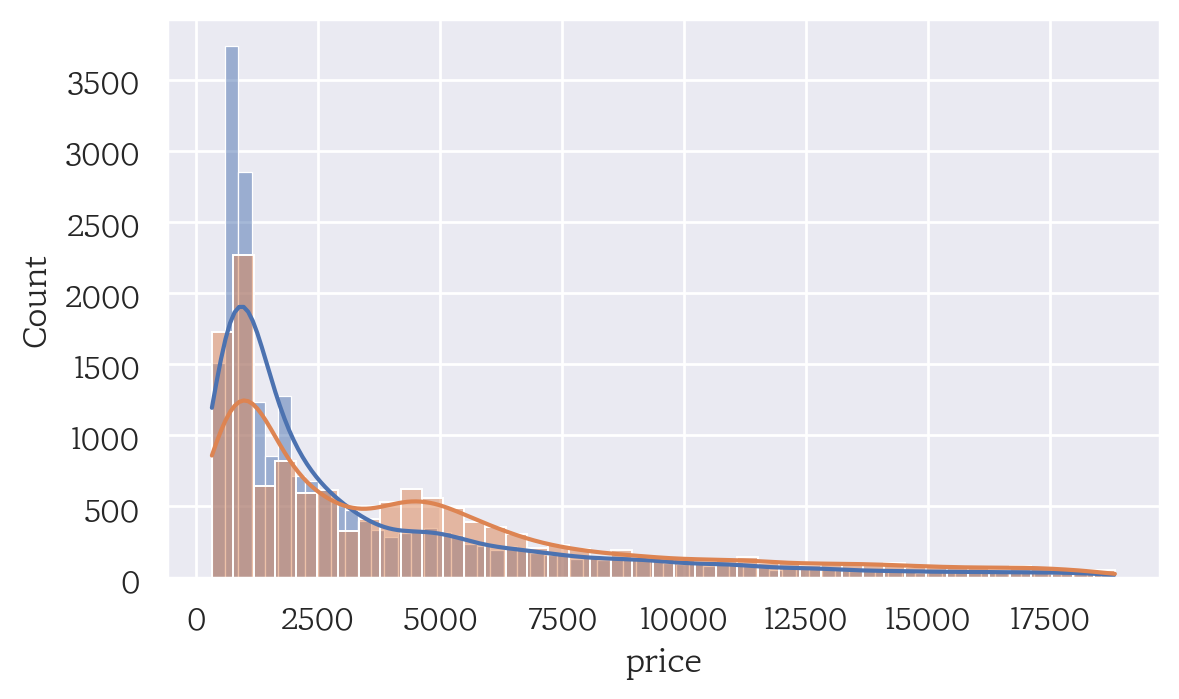

In [19]:
width_px = 1200
height_px = 720
rows = 1
cols = 1
figsize = (width_px/ my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# histogram 그리기
sb.histplot(data = df3[df3['cut'] == 'Ideal'], x = 'price', kde = True)
sb.histplot(data = df3[df3['cut'] == 'Premium'], x = 'price', kde = True)
# 그래프 꾸미기
ax.grid() 

# 출력
plt.tight_layout()
plt.savefig('myplot.png', dpi = my_dpi)
plt.show()
plt.close()

### 데이터 전처리 - 1

In [20]:
premium_df = df3[df3["cut"] == "Premium"]

ideal_df = df3[df3["cut"] == "Ideal"]

df_tmp = pd.concat([premium_df,ideal_df])

df_tmp = df_tmp[["cut", "price"]]
df_tmp = df_tmp.reset_index(drop = True)
df_tmp

,cut,price
0,Premium,326
1,Premium,334
2,Premium,342
3,Premium,345
4,Premium,345
...,...,...
35323,Ideal,2756
35324,Ideal,2756
35325,Ideal,2756
35326,Ideal,2757


### 데이터 전처리 - 2

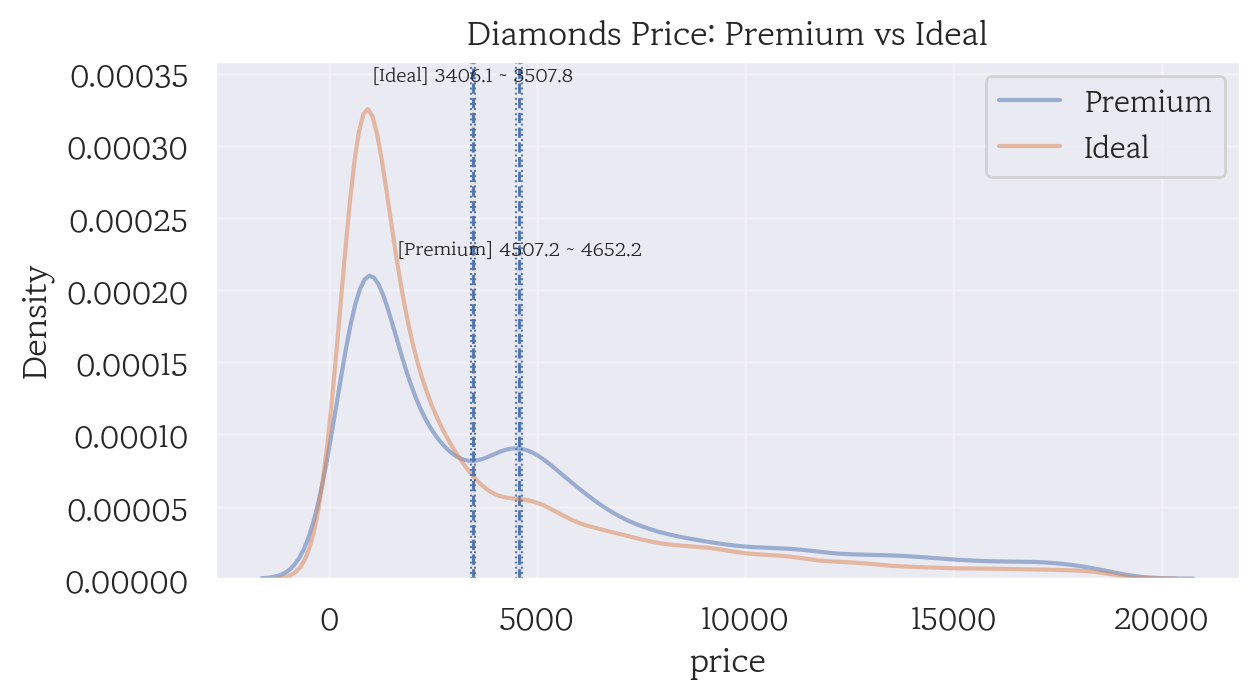

In [21]:
data = df_tmp[['cut', 'price']]

# 1) 그래프 초기화
width_px = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 집단별로 반복
for c in data['cut'].unique():

    subset = data[data['cut'] == c]['price']

    # KDE Plot
    sb.kdeplot(x=subset, fill=False, alpha=0.5, ax=ax, label=c)

    # 신뢰구간 계산
    clevel = 0.95
    dof = len(subset) - 1
    sp_mean = subset.mean()
    sp_std = subset.std(ddof=1)
    sp_std_error = sp_std / sqrt(len(subset))

    cmin, cmax = t.interval(
        clevel,
        dof,
        loc=sp_mean,
        scale=sp_std_error
    )

    # 신뢰구간 선
    ax.axvline(cmin, linestyle=':', linewidth=0.7)
    ax.axvline(cmax, linestyle=':', linewidth=0.7)

    # 평균 표시
    ymin, ymax = ax.get_ylim()
    ax.fill_between([cmin, cmax], 0, ymax, alpha=0.1)
    ax.axvline(sp_mean, linestyle='--', linewidth=1)

    # 텍스트
    ax.text(
        x=(cmin + cmax) / 2,
        y=ymax,
        s=f"[{c}] {cmin:.1f} ~ {cmax:.1f}",
        ha="center",
        va="bottom",
        fontsize=7
    )

# 3) 그래프 꾸미기
ax.grid(True, alpha=0.3)
ax.set_title("Diamonds Price: Premium vs Ideal")
ax.legend()

# 4) 출력
plt.tight_layout()
plt.show()
plt.close()


In [22]:
data = df_tmp[['cut', 'price']]   # 검사하려는 데이터

normal_dist = True
report = []

# 1) 정규성 검정 (집단별 price)
for c in data['cut'].unique():

    subset = data[data['cut'] == c]['price']
    s, p = normaltest(subset)

    normalize = p > 0.05

    report.append({
        "field": f"{c} price",
        "statistic": s,
        "p-value": p,
        "result": normalize
    })

    normal_dist = normal_dist and normalize


# 2) 등분산성 검정 (Premium vs Ideal)
premium = data[data['cut'] == 'Premium']['price']
ideal   = data[data['cut'] == 'Ideal']['price']

if normal_dist:
    n = "Bartlett"
    s, p = bartlett(premium, ideal)
else:
    n = "Levene"
    s, p = levene(premium, ideal, center='median')

report.append({
    "field": n,
    "statistic": s,
    "p-value": p,
    "result": p > 0.05
})

# 3) 결과 정리
report_df = DataFrame(report).set_index('field')
report_df


,statistic,p-value,result
field,,,
Premium price,2756.236244,0.000000e+00,False
Ideal price,7268.307291,0.000000e+00,False
Levene,422.026653,3.104449e-93,False


In [23]:
# 두 집단 데이터
premium = df_tmp.loc[df_tmp["cut"] == "Premium", "price"]
ideal   = df_tmp.loc[df_tmp["cut"] == "Ideal", "price"]

s, p = ttest_ind(
    premium,
    ideal,
    equal_var=False,
    alternative="greater"   # Premium > Ideal
)

print(
    "statistic: {0:.3f}, p-value: {1:.6f}, 가설 판단: {2}".format(
        s, p, "대립가설 채택" if p < 0.05 else "귀무가설 채택"
    )
)


statistic: 24.844, p-value: 0.000000, 가설 판단: 대립가설 채택


### 가설설정
- 귀무가설: premium 은 Ideal보다 가격이 높지 않다
- 대립가설: premium 은 Ideal보다 가격이 높다

- 정규성, 등분산성을 모두 충족하지 않으므로, welch - t-test 검정방법 선택하였다

- 검정결과, premium과 ideal의 평균값 차이는 1122정도로 유의미한 차이를 보였다.

- p-value <=0.05 이므로 대립가설을 채택하였으며,

  대립가설 채택 -> premium 은 Ideal 보다 가격이 높다(차이가 난다)

## 미션 6

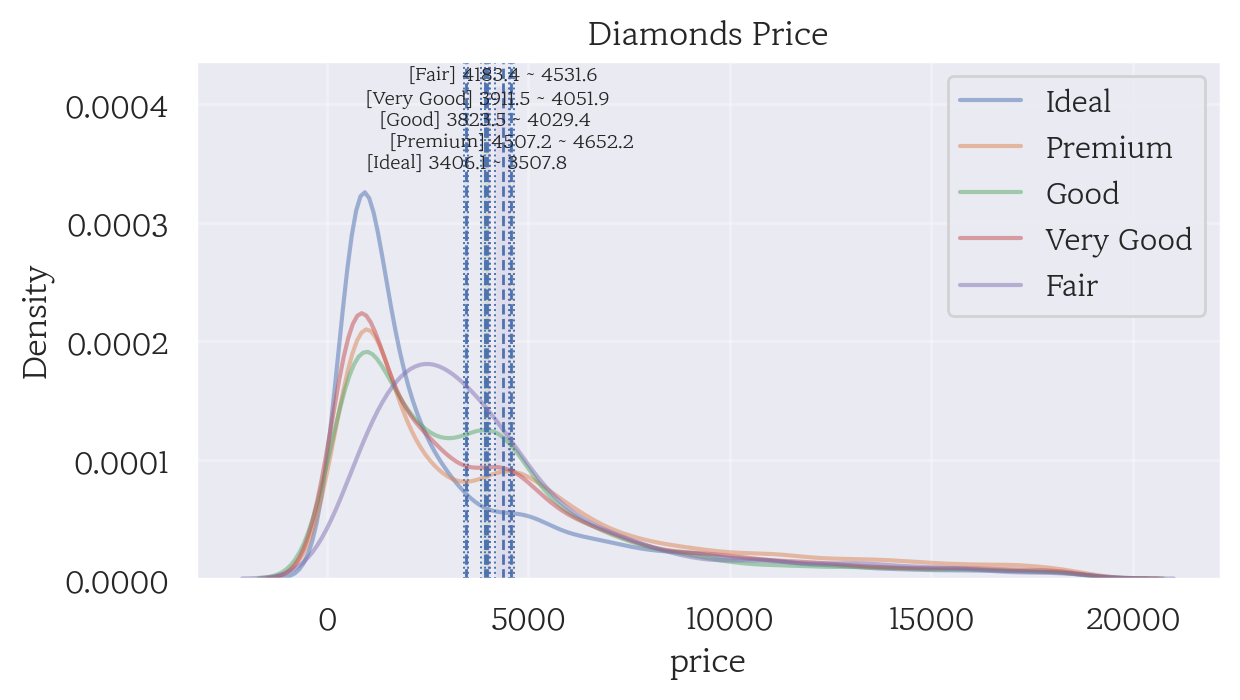

In [24]:
data = df3[['cut', 'price']]

# 1) 그래프 초기화
width_px = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 집단별로 반복
for c in data['cut'].unique():

    subset = data[data['cut'] == c]['price']

    # KDE Plot
    sb.kdeplot(x=subset, fill=False, alpha=0.5, ax=ax, label=c)

    # 신뢰구간 계산
    clevel = 0.95
    dof = len(subset) - 1
    sp_mean = subset.mean()
    sp_std = subset.std(ddof=1)
    sp_std_error = sp_std / sqrt(len(subset))

    cmin, cmax = t.interval(
        clevel,
        dof,
        loc=sp_mean,
        scale=sp_std_error
    )

    # 신뢰구간 선
    ax.axvline(cmin, linestyle=':', linewidth=0.7)
    ax.axvline(cmax, linestyle=':', linewidth=0.7)

    # 평균 표시
    ymin, ymax = ax.get_ylim()
    ax.fill_between([cmin, cmax], 0, ymax, alpha=0.1)
    ax.axvline(sp_mean, linestyle='--', linewidth=1)

    # 텍스트
    ax.text(
        x=(cmin + cmax) / 2,
        y=ymax,
        s=f"[{c}] {cmin:.1f} ~ {cmax:.1f}",
        ha="center",
        va="bottom",
        fontsize=7
    )

# 3) 그래프 꾸미기
ax.grid(True, alpha=0.3)
ax.set_title("Diamonds Price")
ax.legend()

# 4) 출력
plt.tight_layout()
plt.show()
plt.close()


In [25]:
data = df3[['cut', 'price']]   # 검사하려는 데이터

normal_dist = True
report = []

# 1) 정규성 검정 (집단별 price)
for c in data['cut'].unique():

    subset = data[data['cut'] == c]['price']
    s, p = normaltest(subset)

    normalize = p > 0.05

    report.append({
        "field": f"{c} price",
        "statistic": s,
        "p-value": p,
        "result": normalize
    })

    normal_dist = normal_dist and normalize


# 2) 등분산성 검정 (Premium vs Ideal)
premium = data[data['cut'] == 'Premium']['price']
ideal   = data[data['cut'] == 'Ideal']['price']

if normal_dist:
    n = "Bartlett"
    s, p = bartlett(premium, ideal)
else:
    n = "Levene"
    s, p = levene(premium, ideal, center='median')

report.append({
    "field": n,
    "statistic": s,
    "p-value": p,
    "result": p > 0.05
})

# 3) 결과 정리
report_df = DataFrame(report).set_index('field')
report_df


,statistic,p-value,result
field,,,
Ideal price,7268.307291,0.000000e+00,False
Premium price,2756.236244,0.000000e+00,False
Good price,1568.698291,0.000000e+00,False
Very Good price,3357.874309,0.000000e+00,False
Fair price,542.065306,1.958909e-118,False
Levene,422.026653,3.104449e-93,False


In [26]:
df_melt = df3[['cut', 'price']]
df_melt

,cut,price
0,Ideal,326
1,Premium,326
2,Good,327
3,Premium,334
4,Good,335
...,...,...
53935,Ideal,2757
53936,Good,2757
53937,Very Good,2757
53938,Premium,2757


In [27]:
lm = ols('price ~ C(cut)', data = df_melt).fit()
anova_result = anova_lm(lm)
anova_result

,df,sum_sq,mean_sq,F,PR(>F)
C(cut),4.0,1.096482e+10,2.741206e+09,174.641241,6.632830e-149
Residual,53915.0,8.462613e+11,1.569621e+07,NaN,NaN


In [28]:
s = anova_result['F'].iloc[0]
p = anova_result['PR(>F)'].iloc[0]
'statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택'.format(s, p, '대립' if p < 0.05 else '귀무')

'statistic: 174.641, p-value: 0.000, 대립가설 채택'

- F = 174.6412 -> 집단 간 차이가 집단 내 변동보다 압도적으로 크다
- p-value = 0.05보다 훨씬 작음
- 즉, 두가지 사실로부터 귀무가설이 기각
- cut별로 가격 수준이 통계적으로 유의하게 다르다고 볼 수 있다.

In [29]:
gh_df = pairwise_gameshowell(df3, dv = 'price', between = 'cut')
gh_df

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Fair,Good,4357.500932,3926.403509,431.097423,103.147981,4.179407,2816.976656,2.909058e-04,0.118142
1,Fair,Very Good,4357.500932,3981.664101,375.836832,95.729210,3.926041,2166.177565,8.461989e-04,0.096515
2,Fair,Premium,4357.500932,4579.684543,-222.183611,96.182450,-2.310022,2207.496380,1.419815e-01,-0.052045
3,Fair,Ideal,4357.500932,3456.941201,900.559731,92.491686,9.736656,1893.295139,0.000000e+00,0.237515
4,Good,Very Good,3926.403509,3981.664101,-55.260592,63.562119,-0.869395,9670.283217,9.081356e-01,-0.014305
5,Good,Premium,3926.403509,4579.684543,-653.281034,64.242703,-10.168953,10091.431828,8.124945e-12,-0.156311
6,Good,Ideal,3926.403509,3456.941201,469.462308,58.572802,8.015022,7483.505572,0.000000e+00,0.124058
7,Very Good,Premium,3981.664101,4579.684543,-598.020442,51.494665,-11.613251,25830.918889,7.857603e-12,-0.143808
8,Very Good,Ideal,3981.664101,3456.941201,524.722900,44.219326,11.866370,24329.637709,0.000000e+00,0.136128
9,Premium,Ideal,4579.684543,3456.941201,1122.743342,45.192153,24.843767,26550.121379,0.000000e+00,0.278896


- 모든 컷 등급 간 평균 가격 차이가 유의한 것은 아니다.

- Ideal 컷은 다수의 다른 컷과 통계적으로 유의한 가격 차이를 보인다.

- 일부 컷 조합(Fair–Premium, Good–Very Good)에서는 평균 가격 차이가 유의하지 않다.

- 컷 등급에 따른 가격 구조는 명확한 단일 서열이라기보다는 부분적으로 겹치는 구조를 가진다.

In [30]:
final_table = (
    df3.groupby("cut")["price"].mean().sort_values(ascending=False)
)
final_table

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_2452\1783914469.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df3.groupby("cut")["price"].mean().sort_values(ascending=False)


cut
Premium      4579.684543
Fair         4357.500932
Very Good    3981.664101
Good         3926.403509
Ideal        3456.941201
Name: price, dtype: float64

## 미션 7

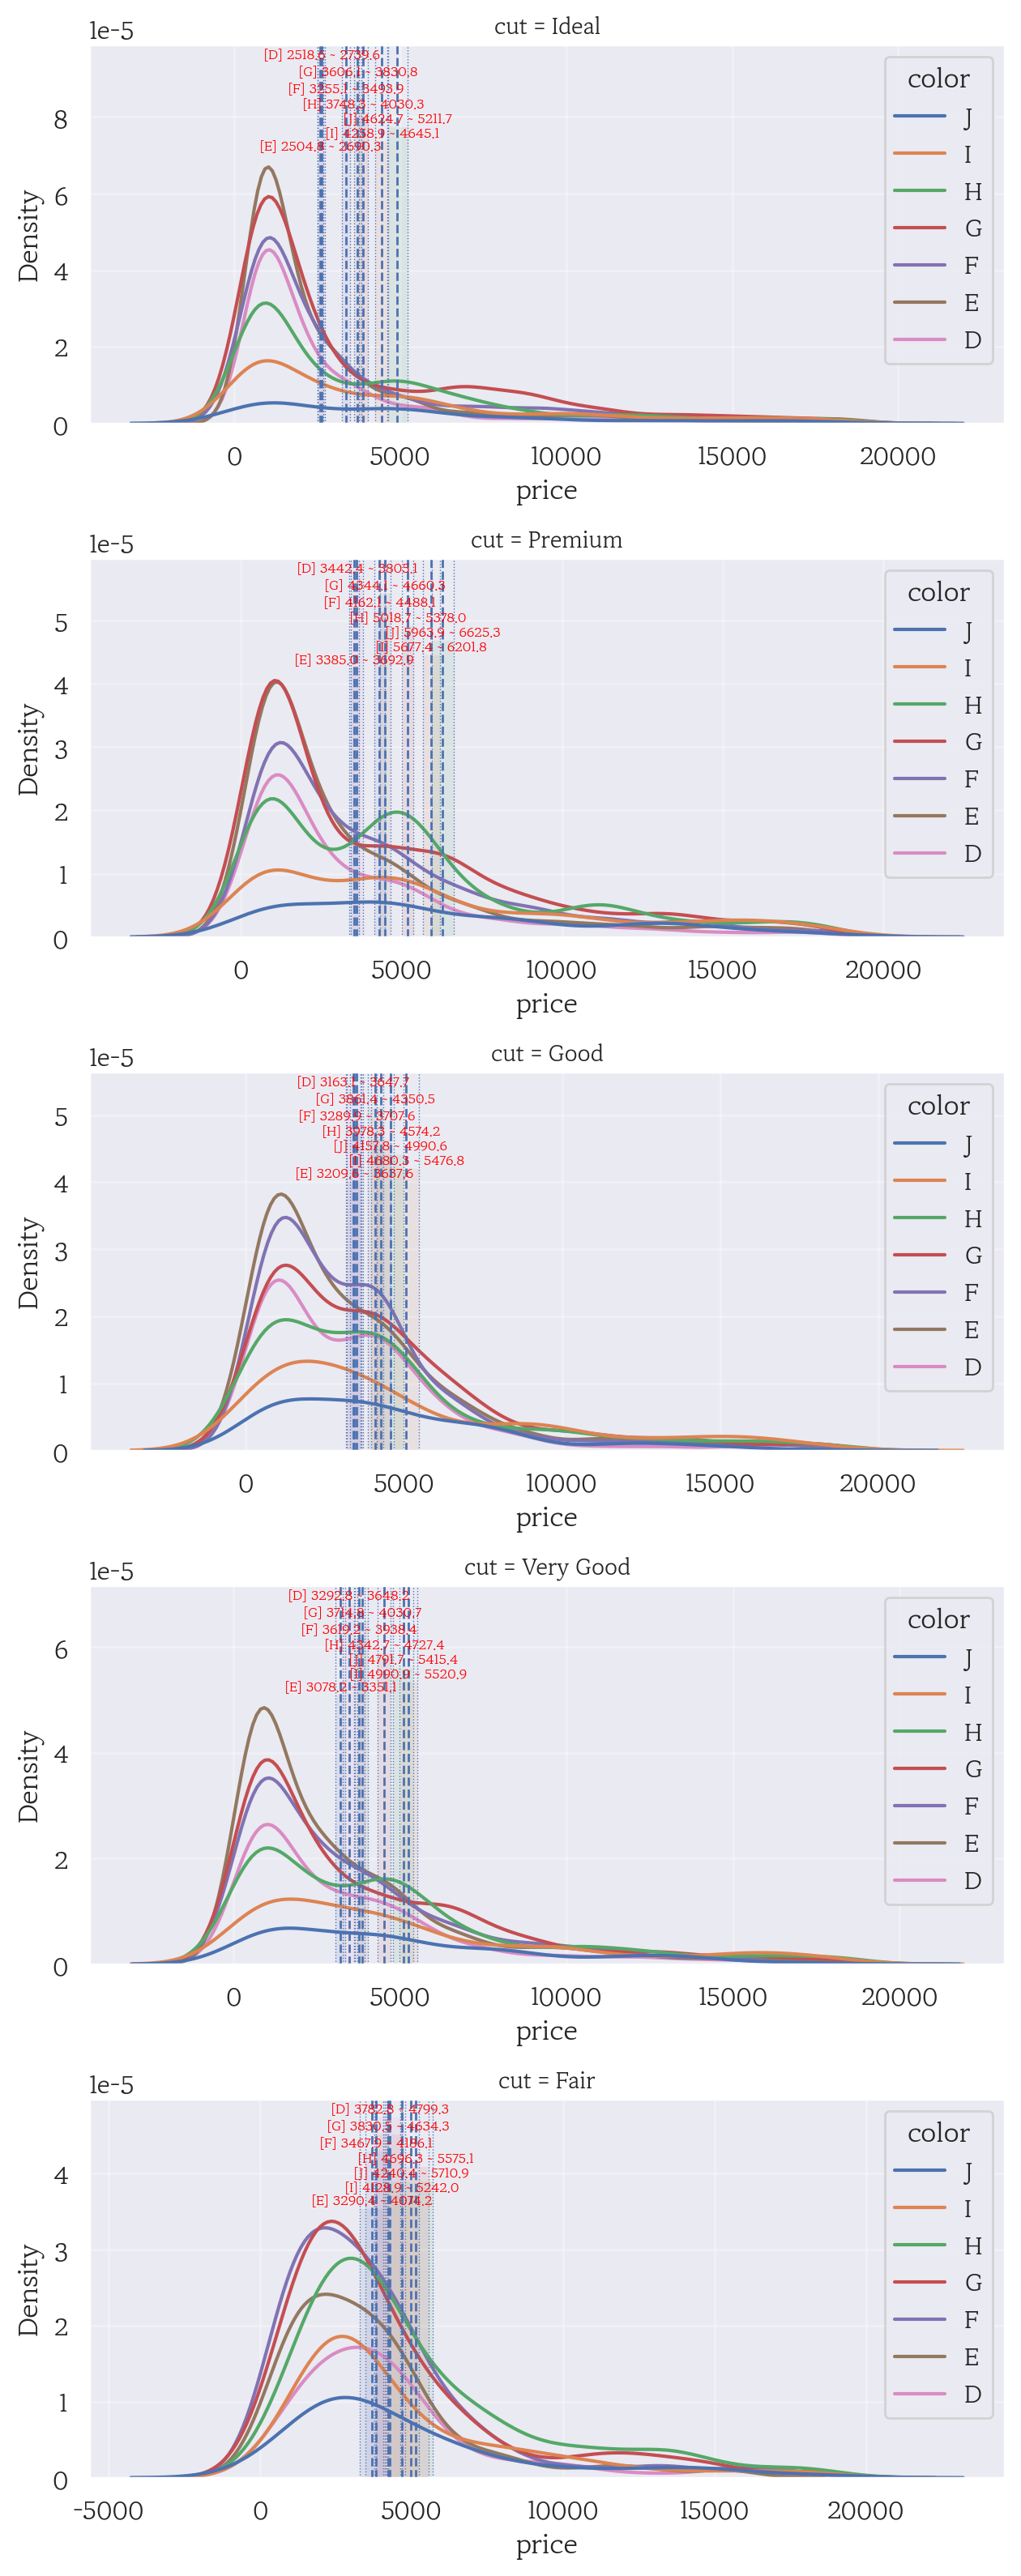

In [31]:
field = 'price'
group_field = 'cut'
hue_field = 'color'
# 시각화 할 필드만 원본 데이터에서 추출
data = df3[[field, group_field, hue_field]]

group_values = data[group_field].unique()
group_count = len(group_values)
hue_values = data[hue_field].unique()

# 1) 그래프 초기화
rows = group_count # 그래프 행 수
cols = 1 # 그래프 열 수
width_px = 1280 * cols # 그래프 가로 크기
height_px = 640 * rows # 그래프 세로 크기
figsize = (width_px / my_dpi, height_px / my_dpi)

# ax 객체가 행,열 수에 따라서 리스트가 된다.

fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)
# 2) 그래프 그리기
for i, v in enumerate(group_values):
   temp = data[data[group_field] == v]
   sb.kdeplot(data=temp, x=field, hue=hue_field, ax=ax[i])
   ax[i].grid(True, alpha=0.3)
   ax[i].set_title('{0} = {1}'.format(group_field, v), fontsize=10, pad=5)
   for h in hue_values:
      temp_sub = temp[temp[hue_field] == h]
# 신뢰구간
      max = temp_sub[field].max() # 최대값
      clevel = 0.95 # 신뢰수준
      dof = len(temp_sub[field]) - 1 # 자유도
      sp_mean = temp_sub[field].mean() # 표본평균
      sp_std = temp_sub[field].std(ddof=1) # 표본표준

      sp_std_error = sp_std / sqrt(len(temp_sub[field])) # 표본표준
      cmin, cmax = t.interval(clevel, dof, loc=sp_mean, 
      scale=sp_std_error)
      ax[i].axvline(cmin, linestyle=':', linewidth=0.5)
      ax[i].axvline(cmax, linestyle=':', linewidth=0.5)

   # 평균 표시
      ymin, ymax = ax[i].get_ylim()
      ax[i].fill_between([cmin, cmax], 0, ymax, alpha=0.1)
      ax[i].axvline(sp_mean, linestyle='--', linewidth=1)

   # 텍스트 그리기 
      ax[i].text(x=(cmax-cmin)/2+cmin,y=ymax,
      s="[%s] %0.1f ~ %0.1f" % (h, cmin, cmax),
      horizontalalignment="center",
      verticalalignment="bottom",
      fontdict={"size": 6, "color": "red"})
# 4) 출력
plt.tight_layout() # 여백 제거
plt.show() # 그래프 화면 출력
plt.close() # 그래프 작업 종료

In [32]:
data = df3.copy()
xname = ['color', 'cut']
yname = 'price'

u1 = data[xname[0]].unique()
u2 = data[xname[1]].unique()
equal_var_fields = []
normal_dist = True
report = []

for i in u1:
 for j in u2:
  filtered_data = data[(data[xname[0]] == i) & (data[xname[1]] == j)][yname]
  equal_var_fields.append(filtered_data)
  s, p = normaltest(filtered_data)
  normalize = p > 0.05
  report.append({'field':'{0}, {1}'.format(i, j), 'statistic': s, 'p-value': p, 'result': normalize})
  normal_dist = normal_dist and normalize

# 등분산성 검정 선택
if normal_dist:
 n = "Bartlett"
 s, p = bartlett(*equal_var_fields)
else:
 n = "Levene"
 s, p = levene(*equal_var_fields)

equal_var = p> 0.05
report.append({'field': n, 'statistic': s, 'p-value': p, 'result': p > 0.05})

report_df = DataFrame(report).set_index('field')
report_df

,statistic,p-value,result
field,,,
"E, Ideal",2089.064535,0.000000e+00,False
"E, Premium",853.820680,3.937269e-186,False
"E, Good",362.008075,2.460058e-79,False
"E, Very Good",945.392436,5.136188e-206,False
"E, Fair",95.810733,1.566620e-21,False
"I, Ideal",419.976373,6.357544e-92,False
"I, Premium",147.498574,9.356031e-33,False
"I, Good",82.990275,9.525564e-19,False
"I, Very Good",187.908017,1.571421e-41,False


In [33]:
xname = ['color', 'cut']
yname = 'price'
data = df3[xname + [yname]]

pg_anova = anova(data = df3, dv = yname, between = xname)
display(pg_anova)
for idx in pg_anova.index:
    row = pg_anova.iloc[idx]
    source = row['Source']
    p_val = row['p-unc']

    if p_val <= 0.05:
        print(f' -> {source} 효과는 유의함. (대립가설 채택: p <= 0.05)')
    else:
        print(f' -> {source} 효과는 유의하지 않음. (귀무가설 채택: p > 0.05)')

,Source,SS,DF,MS,F,p-unc,np2
0,color,2.545214e+10,6.0,4.242023e+09,279.037528,0.000000e+00,0.030134
1,cut,9.633214e+09,4.0,2.408304e+09,158.416659,5.022783e-135,0.011623
2,color * cut,1.631176e+09,24.0,6.796565e+07,4.470737,1.723890e-12,0.001987
3,Residual,8.191780e+11,53885.0,1.520234e+07,NaN,NaN,NaN


 -> color 효과는 유의함. (대립가설 채택: p <= 0.05)
 -> cut 효과는 유의함. (대립가설 채택: p <= 0.05)
 -> color * cut 효과는 유의함. (대립가설 채택: p <= 0.05)
 -> Residual 효과는 유의하지 않음. (귀무가설 채택: p > 0.05)


In [34]:
xname = ['cut', 'color']
yname = 'price'
data = data[xname + [yname]]
levels = {} # 빈 딕셔너리 만들기

# 예: {'': 2, '': 3} 이런 식 결과
for factor in xname: # 요인을 하나씩 꺼냄
 level_count = data[factor].nunique() # 요인의 수준 수 계산
 levels[factor] = level_count # 딕셔너리에 저장

pvals = {} # 빈 딕셔너리 만들기

# 예: {'': 1.30e-20, '': 2.01e-17, ' * ': 0.105}
for index, row in pg_anova.iterrows(): # 행을 하나씩 꺼냄
    source_name = row['Source'] # 요인 이름
    p_value = row['p-unc'] # 각 요인의 p-value
    pvals[source_name] = p_value # 딕셔너리에 저장

for factor in xname:
    print(f"\n[{factor}]")
    if levels[factor] == 2:
        print(f"- {levels[factor]}수준 요인이므로 사후검정이 필요 없습니다.")
        continue
    
    p_val = pvals.get(factor, None)
    if p_val is None:
        print("- ANOVA 결과에서 해당 요인을 찾을 수 없습니다.")
        continue
    if p_val > 0.05:
        print(f"- 주효과 유의하지 않음 (p={p_val:.3g}) → 사후검정 수행 안 함")
        continue

    print(f"- 주효과 유의 (p={p_val:.3g}) → 사후검정 수행")

    if equal_var:
        print(" · Tukey HSD 사용 (등분산 충족)")
        hoc_df = pairwise_tukey(data=data, dv=yname, between=factor)
    else:
        print(" · Games–Howell 사용 (등분산 불충족)")
        hoc_df = pairwise_gameshowell(data=data, dv=yname, between=factor)
    
    display(hoc_df)

# 상호작용 자동 처리
interaction_names = [src for src in pvals.keys() if '*' in src]

for inter in interaction_names:
    p_val = pvals[inter]
    print(f"\n[{inter}] 상호작용 효과")
    if p_val <= 0.05:
        print(f"- 상호작용 유의 (p={p_val:.3g}) → 단순주효과 분석 필요")
    else:
        print(f"- 상호작용 유의하지 않음 (p={p_val:.3g}) → 단순주효과 분석 필요 없음")


[cut]
- 주효과 유의 (p=5.02e-135) → 사후검정 수행
 · Games–Howell 사용 (등분산 불충족)


,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Fair,Good,4357.500932,3926.403509,431.097423,103.147981,4.179407,2816.976656,2.909058e-04,0.118142
1,Fair,Very Good,4357.500932,3981.664101,375.836832,95.729210,3.926041,2166.177565,8.461989e-04,0.096515
2,Fair,Premium,4357.500932,4579.684543,-222.183611,96.182450,-2.310022,2207.496380,1.419815e-01,-0.052045
3,Fair,Ideal,4357.500932,3456.941201,900.559731,92.491686,9.736656,1893.295139,0.000000e+00,0.237515
4,Good,Very Good,3926.403509,3981.664101,-55.260592,63.562119,-0.869395,9670.283217,9.081356e-01,-0.014305
5,Good,Premium,3926.403509,4579.684543,-653.281034,64.242703,-10.168953,10091.431828,8.124945e-12,-0.156311
6,Good,Ideal,3926.403509,3456.941201,469.462308,58.572802,8.015022,7483.505572,0.000000e+00,0.124058
7,Very Good,Premium,3981.664101,4579.684543,-598.020442,51.494665,-11.613251,25830.918889,7.857603e-12,-0.143808
8,Very Good,Ideal,3981.664101,3456.941201,524.722900,44.219326,11.866370,24329.637709,0.000000e+00,0.136128
9,Premium,Ideal,4579.684543,3456.941201,1122.743342,45.192153,24.843767,26550.121379,0.000000e+00,0.278896



[color]
- 주효과 유의 (p=0) → 사후검정 수행
 · Games–Howell 사용 (등분산 불충족)


,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,J,I,5323.818020,5089.973990,233.844030,105.478585,2.216981,5994.796654,2.863349e-01,0.050542
1,J,H,5323.818020,4480.942155,842.875865,95.653249,8.811785,4630.356469,0.000000e+00,0.197475
2,J,G,5323.818020,3996.876551,1326.941469,92.020593,14.420049,4047.092857,2.619793e-12,0.321308
3,J,F,5323.818020,3725.080205,1598.737814,92.289479,17.323078,4083.168908,4.033440e-13,0.405380
4,J,E,5323.818020,3076.752475,2247.065545,90.312202,24.881085,3766.317032,0.000000e+00,0.621285
5,J,D,5323.818020,3168.106436,2155.711584,93.138819,23.145146,4195.388213,2.011835e-12,0.581904
6,I,H,5089.973990,4480.942155,609.031835,79.029825,7.706354,10636.888934,0.000000e+00,0.137839
7,I,G,5089.973990,3996.876551,1093.097439,74.591948,14.654363,9366.395090,4.661493e-12,0.255465
8,I,F,5089.973990,3725.080205,1364.893785,74.923408,18.217188,9392.990932,0.000000e+00,0.328957
9,I,E,5089.973990,3076.752475,2013.221515,72.473877,27.778582,8485.898039,3.681500e-13,0.517411



[color * cut] 상호작용 효과
- 상호작용 유의 (p=1.72e-12) → 단순주효과 분석 필요


### 요인별 유의성 판단

color: F = 279.03, p < 0.001, ηp² = 0.03 → 유의함 (대립가설 채택)

cut: F = 158.41, p < 0.001, ηp² = 0.01 → 유의함 (대립가설 채택)

color * cut: F = 4.47, p < 0.001, ηp² = 0.001 → 유의함 (대립가설 채택)

요약:
color와 cut은 각각 독립적으로 다이아몬드 가격에 유의한 영향을 미치며, 두 요인이 결합될 때 가격에 추가적인 차이를 만들어내는 상호작용 효과 또한 존재한다. 

이는 다이아몬드 가격이 단일 품질 요인만으로 결정되지 않음을 의미한다.

### 기술통계 및 집단별 평균 비교

color 수준별 평균:
전반적으로 색상 등급이 좋아질수록 평균 가격이 상승하는 경향을 보인다. 다만 인접한 색상 등급 간에는 가격 분포가 상당 부분 겹치는 구간도 관찰된다.

cut 수준별 평균:
cut 등급이 높아질수록 평균 가격이 증가하는 패턴이 나타나며, 특히 낮은 컷 등급과 높은 컷 등급 간의 가격 차이가 비교적 뚜렷하다.

color × cut 조합 평균:
동일한 color라도 cut 수준에 따라 평균 가격이 달라지며, 반대로 같은 cut이라도 color 등급에 따라 가격 차이가 발생한다.

요약 해석:
가격은 color나 cut 중 하나만으로 결정되지 않고, 두 요인의 조합에 따라 다르게 형성되는 경향을 보인다.

### 사후검정(post-hoc)

color: 여러 수준으로 구성된 요인이며, 전체 평균 차이가 유의하므로 사후검정을 통해 구체적인 등급 간 차이를 확인할 필요가 있다.

cut: 등급 간 평균 차이가 존재하므로, 어떤 컷 조합에서 가격 차이가 발생하는지 사후검정을 통해 구체화하였다.

상호작용 (simple effects):
color와 cut의 상호작용 효과가 유의하므로, 특정 color 수준에서 cut에 따른 가격 차이를 살펴보는 해석이 의미 있다.

요약 해석:
사후검정을 통해 모든 등급 간 차이가 동일하게 나타나는 것은 아니며, 일부 조합에서 특히 가격 차이가 크게 발생함을 확인하였다.

### 최종 결론 요약

• color는 다이아몬드 가격에 가장 큰 영향을 미치는 품질 요인 중 하나이다.

• cut 역시 가격에 유의한 영향을 미치며, 전반적인 가격 수준을 조정하는 역할을 한다.

• color와 cut은 서로 독립적으로 작용할 뿐만 아니라, 결합될 때 추가적인 가격 차이를 만들어낸다.

• 이는 다이아몬드 가격이 단일 품질 요소가 아닌, 여러 조건이 함께 작용하는 구조임을 보여준다.

다이아몬드 가격은 color와 cut의 영향을 크게 받으며, 두 요인이 결합될 때 가격 구조가 달라지는 상호작용 효과가 확인되었다

## 미션 8

In [35]:
df4 = origin.filter(['price','carat','x','y','z','depth','table'])
df4.head()

,price,carat,x,y,z,depth,table
0,326,0.23,3.95,3.98,2.43,61.5,55.0
1,326,0.21,3.89,3.84,2.31,59.8,61.0
2,327,0.23,4.05,4.07,2.31,56.9,65.0
3,334,0.29,4.20,4.23,2.63,62.4,58.0
4,335,0.31,4.34,4.35,2.75,63.3,58.0


In [36]:
skew_outlier = {}
for col in df4.columns:
    temp = df4[col].dropna()
    skew_original = temp.skew()
    z_scores = zscore(temp)
    outlier_count = int(np.sum(np.abs(z_scores) > 3))

    data_log = np.log1p(temp - temp.min() + 1)
    skew_log = data_log.skew()

    skew_outlier[col] = {
        'original_skew': skew_original,
        'log_skew': skew_log,
        'outliers(|z|>3)': outlier_count
    }

skew_outlier_df = DataFrame(skew_outlier).T
skew_outlier_df

,original_skew,log_skew,outliers(|z|>3)
price,1.618395,-0.266927,1206.0
carat,1.116646,0.713926,439.0
x,0.378676,0.056805,43.0
y,2.434167,0.141255,34.0
z,1.522423,0.060521,55.0
depth,-0.082294,-2.176133,685.0
table,0.796896,0.159775,336.0


In [37]:
rows = []

for a, b in combinations(df4.columns, 2):
    x = df4[a]
    y = df4[b]

    # 선형성 확인(Ramsey RESET)
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
    reset = linear_reset(model, power = 2, use_f = True)
    linearity_ok = reset.pvalue > 0.05

    # 이상치 존재 여부(|z| > 3 기준)
    a_flag = skew_outlier_df.loc[a, 'outliers(|z|>3)'] > 0
    b_flag = skew_outlier_df.loc[b, 'outliers(|z|>3)'] > 0
    outlier_flag = a_flag or b_flag
    
    # 상관계수 선택 및 계산
    if linearity_ok and not outlier_flag:
        chosen = "pearson"
        corr, pval = pearsonr(x, y)
    else:
        chosen = 'spearman'
        corr, pval = spearmanr(x, y)

    # 유의성 판단 (p <= 0.05)
    significant = pval <= 0.05

    # 상관 강도 계산
    abs_r = abs(corr)
    if abs_r >= 0.80:
        strength = 'Very strong'
    elif abs_r >= 0.60:
        strength = 'Strong'
    elif abs_r >= 0.40:
        strength = 'Medium'
    elif abs_r >= 0.20:
        strength = 'Weak'
    else:
        strength = 'Very weak'
    
    # 행 추가
    rows.append({
        'var_a': a,
        'var_b': b,
        'linearity': linearity_ok,
        'outlier_flag': outlier_flag,
        'chosen': chosen,
        'corr': corr,
        'pval': pval,
        'significant': significant,
        'strength': strength
    })

summary_df = DataFrame(rows)
summary_df

,var_a,var_b,linearity,outlier_flag,chosen,corr,pval,significant,strength
0,price,carat,False,True,spearman,0.962883,0.000000e+00,True,Very strong
1,price,x,False,True,spearman,0.963196,0.000000e+00,True,Very strong
2,price,y,False,True,spearman,0.962719,0.000000e+00,True,Very strong
3,price,z,False,True,spearman,0.957232,0.000000e+00,True,Very strong
4,price,depth,False,True,spearman,0.010020,1.996147e-02,True,Very weak
5,price,table,False,True,spearman,0.171784,0.000000e+00,True,Very weak
6,carat,x,False,True,spearman,0.996117,0.000000e+00,True,Very strong
7,carat,y,False,True,spearman,0.995572,0.000000e+00,True,Very strong
8,carat,z,False,True,spearman,0.993183,0.000000e+00,True,Very strong
9,carat,depth,True,True,spearman,0.030104,2.690416e-12,True,Very weak


In [38]:
# 등장하는 모든 변수 목록 추출
vars =sorted(set(summary_df['var_a']).union(summary_df['var_b']))

# 빈 상관행렬 생성 (NaN으로 초기화)
corr_matrix = DataFrame(np.nan, index = vars, columns = vars)

# summary_df 내용 반영하여 대칭 행렬 채우기
for _, row in summary_df.iterrows():
    a, b, r = row['var_a'], row['var_b'], row['corr']
    corr_matrix.loc[a,b] = r
    corr_matrix.loc[b,a] = r # 대칭

# 대각선을 1로 설정
np.fill_diagonal(corr_matrix.values, 1)

corr_matrix

,carat,depth,price,table,x,y,z
carat,1.000000,0.030104,0.962883,0.194980,0.996117,0.995572,0.993183
depth,0.030104,1.000000,0.010020,-0.245061,-0.023442,-0.025425,0.103498
price,0.962883,0.010020,1.000000,0.171784,0.963196,0.962719,0.957232
table,0.194980,-0.245061,0.171784,1.000000,0.202231,0.195734,0.159878
x,0.996117,-0.023442,0.963196,0.202231,1.000000,0.997895,0.987355
y,0.995572,-0.025425,0.962719,0.195734,0.997895,1.000000,0.987068
z,0.993183,0.103498,0.957232,0.159878,0.987355,0.987068,1.000000


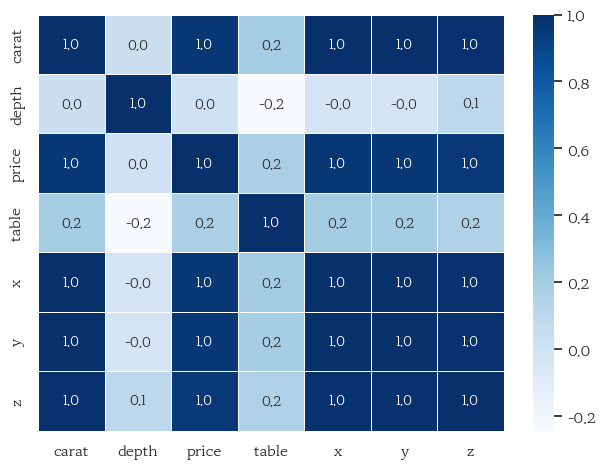

In [39]:
width_px = 1200
height_px = 640
rows = 1
cols = 1
figsize = (width_px/ my_dpi, height_px / my_dpi)

# lmplot 그리기
sb.heatmap(data=corr_matrix, annot = True, fmt = '0.1f', linewidth = 0.5,
           cmap = 'Blues', annot_kws = {'size': 10}) # col, row 선택사항

# 출력
plt.tight_layout()
plt.show()
plt.close()

### 인사이트

본 연구에서는 주요 연속형 변수들 간의 상관구조를 파악하기 위해, 선형성 및 이상치 여부를 사전 점검한 후 피어슨 또는 스피어만 상관계수를 선택적으로 적용하였다. 분석 결과는 다음과 같다. 

1. 다이아몬드 가격은 무게(carat)에 가장 크게 반응한다.
2. x,y,z 값들은 물리적 크기 표현으로써 유사한 패턴을 보인다.
3. 데이터의 왜도와 비선형성을 고려할때, spearman 상관계수가 더 타당하다.

## 미션 9

1. 상관이 높다-> 두 변수가 양의 상관, 음의 상관성이 강하게 존재한다는 것을 의미한다.
2. 원인이라고 하면 안된다. 그 이유는, 상관분석은 변수 간 패턴을 요약하여 보여준다는 의미이지 원인과 결과를 나타내는 분석이 아니기 때문이다.
3. 즉, 상관분석은 변수 간 연관성을 보여줄 뿐, 원인이나 작동 매커니즘을 설명하지는 못한다.

## 미션 10

In [40]:
df5 = df3.copy()

# 종속변수
df5['log_price'] = np.log(df5['price'])

# 범주형 존재하니 더미추가...
df5 = pd.get_dummies(df5, columns=['cut', 'color','clarity'], drop_first=True)
df5 = df5.astype(float)
display(df5)
print(df5.info())


,price,carat,x,y,z,depth,table,log_price,cut_Good,cut_Very Good,...,color_F,color_E,color_D,clarity_SI2,clarity_SI1,clarity_VS2,clarity_VS1,clarity_VVS2,clarity_VVS1,clarity_IF
0,326.0,0.23,3.95,3.98,2.43,61.5,55.0,5.786897,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,326.0,0.21,3.89,3.84,2.31,59.8,61.0,5.786897,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,327.0,0.23,4.05,4.07,2.31,56.9,65.0,5.789960,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,334.0,0.29,4.20,4.23,2.63,62.4,58.0,5.811141,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,335.0,0.31,4.34,4.35,2.75,63.3,58.0,5.814131,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53935,2757.0,0.72,5.75,5.76,3.50,60.8,57.0,7.921898,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
53936,2757.0,0.72,5.69,5.75,3.61,63.1,55.0,7.921898,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
53937,2757.0,0.70,5.66,5.68,3.56,62.8,60.0,7.921898,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
53938,2757.0,0.86,6.15,6.12,3.74,61.0,58.0,7.921898,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
Index: 53920 entries, 0 to 53939
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          53920 non-null  float64
 1   carat          53920 non-null  float64
 2   x              53920 non-null  float64
 3   y              53920 non-null  float64
 4   z              53920 non-null  float64
 5   depth          53920 non-null  float64
 6   table          53920 non-null  float64
 7   log_price      53920 non-null  float64
 8   cut_Good       53920 non-null  float64
 9   cut_Very Good  53920 non-null  float64
 10  cut_Premium    53920 non-null  float64
 11  cut_Ideal      53920 non-null  float64
 12  color_I        53920 non-null  float64
 13  color_H        53920 non-null  float64
 14  color_G        53920 non-null  float64
 15  color_F        53920 non-null  float64
 16  color_E        53920 non-null  float64
 17  color_D        53920 non-null  float64
 18  clarity_SI2

In [41]:
yname = 'log_price'

x = df5.drop([yname, 'price'], axis = 1)
y = df5[yname]
X = sm.add_constant(x)

fit = sm.OLS(y, X).fit()
tbl1 = fit.summary()
print(tbl1)

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                 1.235e+05
Date:                Mon, 29 Dec 2025   Prob (F-statistic):               0.00
Time:                        18:10:23   Log-Likelihood:                 30106.
No. Observations:               53920   AIC:                        -6.016e+04
Df Residuals:                   53896   BIC:                        -5.995e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -4.7081      0.051    -92.483

In [42]:
def ols_report(tbl, data):

    # 독립변수 이름(상수항 제외)
    xnames = [n for n in fit.model.exog_names if n != 'const']

    # 독립변수 부분 데이터 (VIF 계산용)
    indi_df = data.filter(xnames)

    # 독립변수 결과를 누적
    variables = []
    for i, v in enumerate(tbl.tables[1].data):
        # 한 행의 변수명 추출 후 목록에 있는지 확인
        name = v[0].strip()
        if name not in xnames:
            continue
        
        # VIF 계산을 위해 열 인덱스 조회
        j =list(indi_df.columns).index(name)
        vif = variance_inflation_factor(indi_df, j)

        # 유의확률과 별표 표시 함수
        p = float(v[4].strip())
        stars = lambda p:(
            '***' if p< 0.001 else
            '**' if p< 0.01 else
            '*' if p< 0.05 else
            ''
        )

        # 한 변수에 대한 보고 정보 추가
        variables.append({
            '종속변수': yname,
            '독립변수': name,
            'B': v[1].strip(),
            '표준오차': v[2].strip(),
            'Beta': float(fit.params[name]) * (data[name].std(ddof=1)/data[yname].std(ddof=1)),
            't': '%s%s' % (v[3].strip(), stars(p)),
            'p-value': p,
            '공차': 1/vif,
            'vif':vif,
        })

    rdf = DataFrame(variables)

# summary 표에서 적합도 정보를 key-value로 추출
    result_dict = {}
    for i in [0,2]:
        for item in tbl.tables[i].data:
            n = len(item)
            for i in range(0, n, 2):
                key = item[i].strip()[:-1]
                value = item[i+1].strip()
                if not key or not value:
                    continue
                result_dict[key] =  value

# 적합도 보고 문자열 구성
    result_report = f"""
    R({result_dict['R-squared']}), 
    R^2({result_dict['Adj. R-squared']}), 
    F({result_dict['F-statistic']}), 
    유의확률({result_dict['Prob (F-statistic)']}), 
    Durbin-Watson({result_dict['Durbin-Watson']})
    """

# 모형 보고 문자 구성
    tpl = '%s에 대하여 %s로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 %s(F(%s,%s) = %s, p %s 0.05)'
    model_report = tpl % (
    rdf['종속변수'][0],
    ','.join(list(rdf['독립변수'])),
    '유의하다' if float(result_dict['Prob (F-statistic)']) <= 0.05 else '유의하지 않다',
    result_dict['Df Model'],
    result_dict['Df Residuals'],
    result_dict['F-statistic'],
    '<=' if float(result_dict['Prob (F-statistic)']) <= 0.05 else '=>'
)

# 변수별 보고 문장 리스트 구성
    variable_reports = []
    s = '%s의 회귀계수는 %s(p %s 0.05)로, %s에 대하여 %s 예측변인인 것으로 나타났다.'

    for i in rdf.index:
        row = rdf.iloc[i]
        variable_reports.append(s % (row['독립변수'],
                                 row['B'],
                                 '<=' if float(row['p-value']) < 0.05 else '>',
                                 row['종속변수'],
                                 '유의미한' if float(row['p-value']) < 0.05 else '유의하지 않은'))
    return rdf, result_report, model_report, variable_reports
rdf, r, m, v = ols_report(tbl1, df5)
display(rdf)
print(m)

,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,log_price,carat,-1.0018,0.006,-0.467822,-157.943***,0.0,0.011583,86.332877
1,log_price,x,1.3370,0.004,1.475191,311.021***,0.0,0.000661,1513.108136
2,log_price,y,0.0196,0.002,0.022054,8.215***,0.0,0.001833,545.518372
3,log_price,z,0.0575,0.005,0.039848,12.379***,0.0,0.001401,713.578611
4,log_price,depth,0.0585,0.001,0.082562,102.622***,0.0,0.001462,684.220767
5,log_price,table,0.0090,0.000,0.019923,25.349***,0.0,0.001509,662.705454
6,log_price,cut_Good,0.0992,0.004,0.028111,24.087***,0.0,0.242524,4.123303
7,log_price,cut_Very Good,0.1376,0.004,0.056537,34.801***,0.0,0.114080,8.765759
8,log_price,cut_Premium,0.1210,0.004,0.052035,30.631***,0.0,0.100323,9.967830
9,log_price,cut_Ideal,0.1668,0.004,0.080538,40.731***,0.0,0.065597,15.244536


log_price에 대하여 carat,x,y,z,depth,table,cut_Good,cut_Very Good,cut_Premium,cut_Ideal,color_I,color_H,color_G,color_F,color_E,color_D,clarity_SI2,clarity_SI1,clarity_VS2,clarity_VS1,clarity_VVS2,clarity_VVS1,clarity_IF로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(23,53896) = 1.235e+05, p <= 0.05)


In [43]:
df6 = df5.drop(columns=['price', "x", "y", "z",'depth','table'])
df6

,carat,log_price,cut_Good,cut_Very Good,cut_Premium,cut_Ideal,color_I,color_H,color_G,color_F,color_E,color_D,clarity_SI2,clarity_SI1,clarity_VS2,clarity_VS1,clarity_VVS2,clarity_VVS1,clarity_IF
0,0.23,5.786897,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.21,5.786897,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.23,5.789960,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.29,5.811141,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.31,5.814131,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53935,0.72,7.921898,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
53936,0.72,7.921898,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
53937,0.70,7.921898,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
53938,0.86,7.921898,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
yname = 'log_price'

x = df6.drop(yname, axis = 1)
y = df6[yname]
X = sm.add_constant(x)

fit = sm.OLS(y, X).fit()
tbl1 = fit.summary()

def ols_report(tbl, data):

    # 독립변수 이름(상수항 제외)
    xnames = [n for n in fit.model.exog_names if n != 'const']

    # 독립변수 부분 데이터 (VIF 계산용)
    indi_df = data.filter(xnames)

    # 독립변수 결과를 누적
    variables = []
    for i, v in enumerate(tbl.tables[1].data):
        # 한 행의 변수명 추출 후 목록에 있는지 확인
        name = v[0].strip()
        if name not in xnames:
            continue
        
        # VIF 계산을 위해 열 인덱스 조회
        j =list(indi_df.columns).index(name)
        vif = variance_inflation_factor(indi_df, j)

        # 유의확률과 별표 표시 함수
        p = float(v[4].strip())
        stars = lambda p:(
            '***' if p< 0.001 else
            '**' if p< 0.01 else
            '*' if p< 0.05 else
            ''
        )

        # 한 변수에 대한 보고 정보 추가
        variables.append({
            '종속변수': yname,
            '독립변수': name,
            'B': v[1].strip(),
            '표준오차': v[2].strip(),
            'Beta': float(fit.params[name]) * (data[name].std(ddof=1)/data[yname].std(ddof=1)),
            't': '%s%s' % (v[3].strip(), stars(p)),
            'p-value': p,
            '공차': 1/vif,
            'vif':vif,
        })

    rdf = DataFrame(variables)

# summary 표에서 적합도 정보를 key-value로 추출
    result_dict = {}
    for i in [0,2]:
        for item in tbl.tables[i].data:
            n = len(item)
            for i in range(0, n, 2):
                key = item[i].strip()[:-1]
                value = item[i+1].strip()
                if not key or not value:
                    continue
                result_dict[key] =  value

# 적합도 보고 문자열 구성
    result_report = f"""
    R({result_dict['R-squared']}), 
    R^2({result_dict['Adj. R-squared']}), 
    F({result_dict['F-statistic']}), 
    유의확률({result_dict['Prob (F-statistic)']}), 
    Durbin-Watson({result_dict['Durbin-Watson']})
    """

# 모형 보고 문자 구성
    tpl = '%s에 대하여 %s로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 %s(F(%s,%s) = %s, p %s 0.05)'
    model_report = tpl % (
    rdf['종속변수'][0],
    ','.join(list(rdf['독립변수'])),
    '유의하다' if float(result_dict['Prob (F-statistic)']) <= 0.05 else '유의하지 않다',
    result_dict['Df Model'],
    result_dict['Df Residuals'],
    result_dict['F-statistic'],
    '<=' if float(result_dict['Prob (F-statistic)']) <= 0.05 else '=>'
)

# 변수별 보고 문장 리스트 구성
    variable_reports = []
    s = '%s의 회귀계수는 %s(p %s 0.05)로, %s에 대하여 %s 예측변인인 것으로 나타났다.'

    for i in rdf.index:
        row = rdf.iloc[i]
        variable_reports.append(s % (row['독립변수'],
                                 row['B'],
                                 '<=' if float(row['p-value']) < 0.05 else '>',
                                 row['종속변수'],
                                 '유의미한' if float(row['p-value']) < 0.05 else '유의하지 않은'))
    return rdf, result_report, model_report, variable_reports
rdf, r, m, v = ols_report(tbl1, df6)
display(rdf)
print(m)

,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,log_price,carat,2.1984,0.004,1.026645,623.619***,0.0,0.228088,4.384269
1,log_price,cut_Good,0.0509,0.010,0.014431,5.169***,0.0,0.276530,3.616240
2,log_price,cut_Very Good,0.0590,0.009,0.024231,6.436***,0.0,0.131430,7.608591
3,log_price,cut_Premium,0.0572,0.009,0.024587,6.312***,0.0,0.118221,8.458768
4,log_price,cut_Ideal,0.0843,0.009,0.040724,9.394***,0.0,0.077610,12.884918
5,log_price,color_I,0.1624,0.008,0.048130,20.574***,0.0,0.381893,2.618538
6,log_price,color_H,0.3193,0.007,0.113563,42.826***,0.0,0.290047,3.447722
7,log_price,color_G,0.4522,0.007,0.181333,62.177***,0.0,0.227364,4.398239
8,log_price,color_F,0.5283,0.007,0.198712,71.213***,0.0,0.260012,3.845977
9,log_price,color_E,0.5252,0.007,0.199607,70.399***,0.0,0.250950,3.984852


log_price에 대하여 carat,cut_Good,cut_Very Good,cut_Premium,cut_Ideal,color_I,color_H,color_G,color_F,color_E,color_D,clarity_SI2,clarity_SI1,clarity_VS2,clarity_VS1,clarity_VVS2,clarity_VVS1,clarity_IF로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(18,53901) = 2.388e+04, p <= 0.05)


### 인사이트

물리적 크기를 나타내는 변수들 중 x, y, z, depth, table은 서로 강한 선형관계를 가져  다중공선성을 유발하였다.

이에 따라 물리적 크기의 대표 변수로 carat만을 유지하고, x, y, z, depth, table은 모형에서 제외하였다.

cut, color, clarity와 같은 품질 변수들은 다이아몬드의 등급 체계를 반영하며, 가격 결정 과정에서 구조적으로 중요한 역할을 하므로 포함하였다.

다중선형회귀모형은 다이아몬드 가격을 물리적 크기(carat), 품질 등급(cut, color, clarity) 등 여러 요인의 상호작용으로 설명한다.

회귀계수는 각 특성이 가격을 어떻게 상대적으로 조정하는지를 나타내는 지표로 해석된다.

## 미션 11

In [45]:
reset_res = linear_reset(fit, power = 2, use_f = True)
print(f'RESET F-statistic: {reset_res.fvalue:.4f}')
print(f'p-value: {reset_res.pvalue:.4f}')

if reset_res.pvalue < 0.05:
    print('선형성/기능형 위배 가능성이 있음 (5% 유의수준)')
else:
     print('선형성 가정 위배 근거 없음 (5% 유의수준)')    

RESET F-statistic: 125853.6338
p-value: 0.0000
선형성/기능형 위배 가능성이 있음 (5% 유의수준)


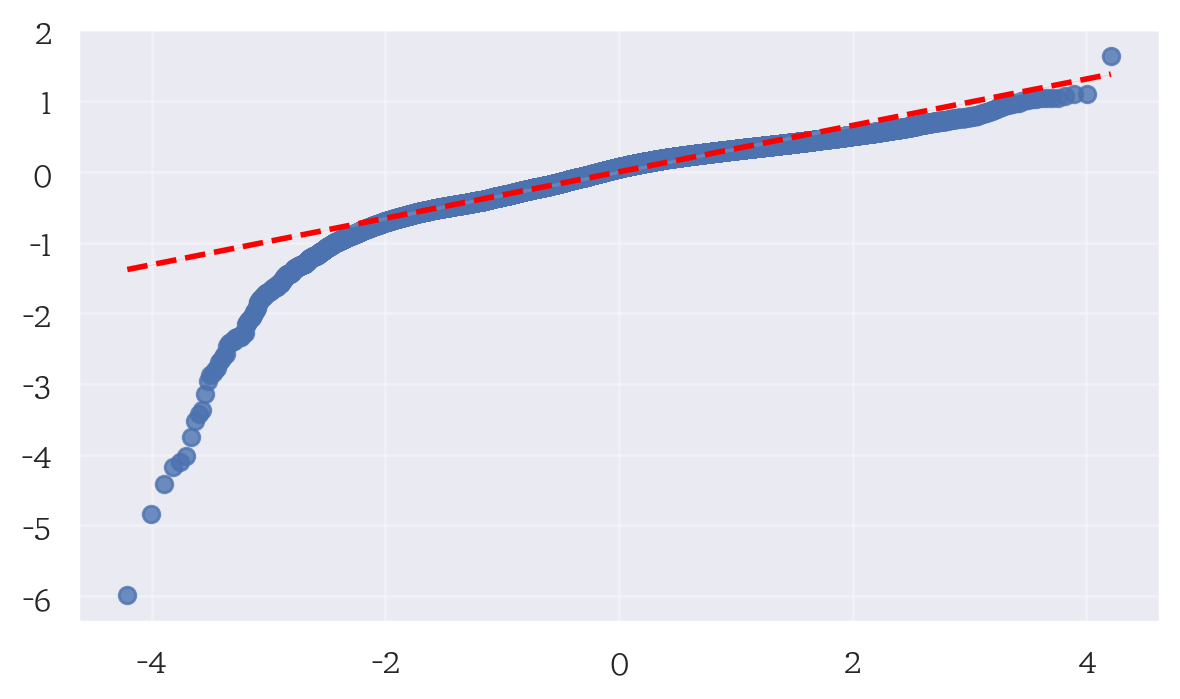

In [ ]:
(x,y), _ = probplot(fit.resid)
width_px = 1200
height_px = 720
rows = 1
cols = 1
figsize = (width_px/ my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# count 그리기
sb.regplot(
             x =x,
             y= y,
             line_kws={
                 'color': 'red',
                 'linestyle': '--',
                 'linewidth': 2
             }                        
          )       

ax.grid(True, alpha = 0.3)

# 출력
plt.tight_layout()
plt.savefig('myplot.png', dpi = my_dpi)
plt.show()
plt.close()

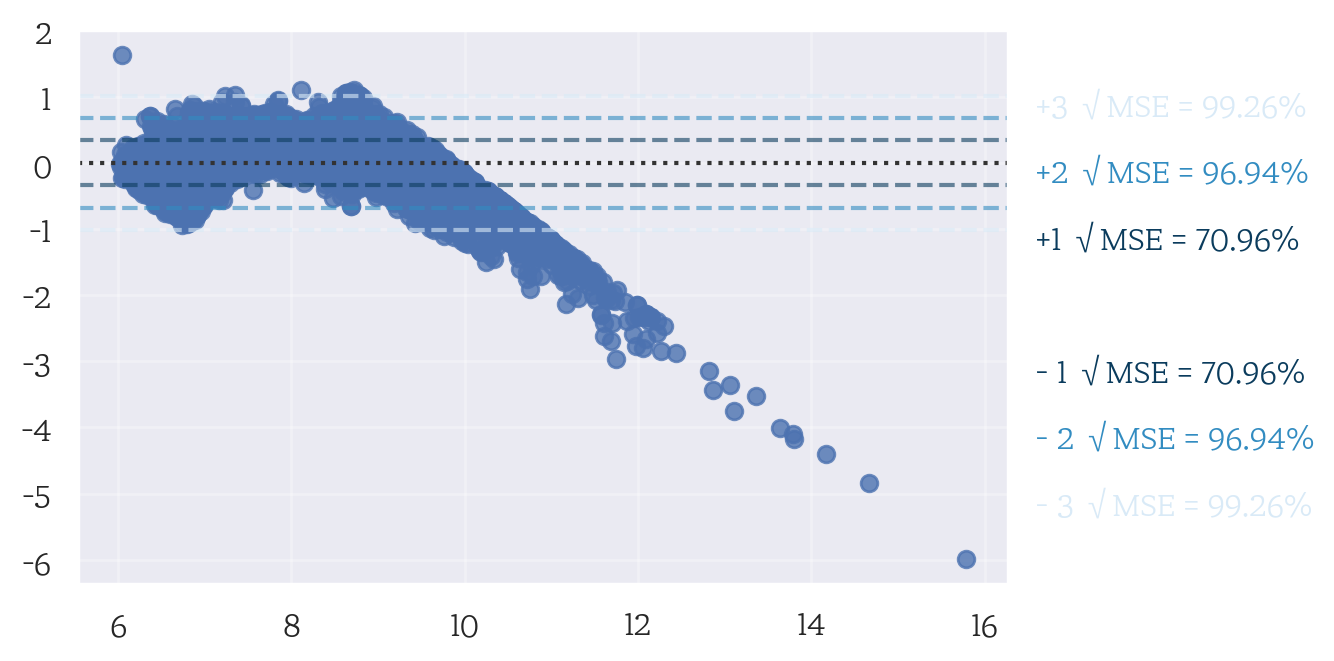

In [56]:
mse_root = np.sqrt(fit.mse_resid)

r = pd.to_numeric(fit.resid, errors='coerce')

r1 = r[(r > -1*mse_root) & (r < 1*mse_root)].count() / r.count() * 100
r2 = r[(r > -2*mse_root) & (r < 2*mse_root)].count() / r.count() * 100
r3 = r[(r > -3*mse_root) & (r < 3*mse_root)].count() / r.count() * 100


mse_r = [r1, r2, r3]
colors = ['#0B3C5D','#328CC1','#D9EAF7']

xmax = fit.fittedvalues.max()
ymin = fit.fittedvalues.min()

width_px = 1200
height_px = 720
rows = 1
cols = 1
figsize = (width_px/ my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

sb.residplot(
             x =fit.fittedvalues,
             y= fit.resid,
             lowess = False                        
          )       

ax.grid(True, alpha = 0.3)

# MSE 3단계 표시
for i, c in enumerate(colors):
    k = i + 1

    # 올바른 k*MSE 위치
    y_pos = k* mse_root
    ax.axhline(+y_pos, color = c, linestyle = '--', alpha = 0.6)
    ax.axhline(-y_pos, color = c, linestyle = '--', alpha = 0.6)

    # 텍스트는 축 좌표계 사용 (그래프 밖으로 안 나감)
    ax.text(x = 1.02, y = 0.5 + 0.12*k,
            s = f" +{k} √MSE = {mse_r[i]:0.2f}%",
            transform = ax.transAxes,
            ha = 'left', va = 'center', fontsize = 11, color = c)
    ax.text(x = 1.02, y = 0.5 - 0.12*k,
            s = f" - {k} √MSE = {mse_r[i]:0.2f}%",
            transform = ax.transAxes,
            ha = 'left', va = 'center', fontsize = 11, color = c)
# 출력
plt.show()
plt.close()

In [49]:
# 잔차의 정규성이 깨진 경우, 로그/제곱근 등 변환 고려
if len(origin) < 5000:
    method = 'Shapiro-Wilk'
    stat, p = shapiro(fit.resid)
    print(f'{method} statistic: {stat:.4f}, p-value{p:.4f}')
    violated = p<0.05
else:
    method = "Anderson-Darling"
    ad_res = anderson(fit.resid, dist='norm')
    crit_levels = ad_res.significance_level.tolist()
    crit_values = ad_res.critical_values.tolist()
    crit_5 = crit_values[crit_levels.index(5.0)] if 5.0 in crit_levels else None
    print(f"{method} statistic: {ad_res.statistic:.4f}, 5% 임계값: {crit_5:.4f}")
    violated = crit_5 is not None and ad_res.statistic > crit_5

print('정규성 가정 위배 가능성이 있음 (5% 유의수준)' if violated else '정규성 가정 위배 근거 없음 (5% 유의수준)')

Anderson-Darling statistic: 472.2482, 5% 임계값: 0.7870
정규성 가정 위배 가능성이 있음 (5% 유의수준)


In [ ]:
dw = durbin_watson(fit.resid)
if 1.5 <= dw <= 2.5:
 interpretation = "잔차는 독립성을 만족함 (자기상관 없음)"
elif dw < 1.5:
 interpretation = "잔차에 양(+)의 자기상관이 존재할 가능성 있음 (독립성 위반)"
else:
 interpretation = "잔차에 음(–)의 자기상관이 존재할 가능성 있음 (독립성 위반)"
print(f"Durbin–Watson: {dw:.3f}")
print(interpretation)

Durbin–Watson: 0.758
잔차에 양(+)의 자기상관이 존재할 가능성 있음 (독립성 위반)


In [ ]:
m

print('\n'.join(v))

price의 회귀계수는 -8.988e-06(p <= 0.05)로, log_price에 대하여 유의미한 예측변인인 것으로 나타났다.
carat의 회귀계수는 2.2782(p <= 0.05)로, log_price에 대하여 유의미한 예측변인인 것으로 나타났다.
cut_Good의 회귀계수는 0.0568(p <= 0.05)로, log_price에 대하여 유의미한 예측변인인 것으로 나타났다.
cut_Very Good의 회귀계수는 0.0666(p <= 0.05)로, log_price에 대하여 유의미한 예측변인인 것으로 나타났다.
cut_Premium의 회귀계수는 0.0650(p <= 0.05)로, log_price에 대하여 유의미한 예측변인인 것으로 나타났다.
cut_Ideal의 회귀계수는 0.0933(p <= 0.05)로, log_price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_I의 회귀계수는 0.1703(p <= 0.05)로, log_price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_H의 회귀계수는 0.3314(p <= 0.05)로, log_price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_G의 회귀계수는 0.4686(p <= 0.05)로, log_price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_F의 회귀계수는 0.5465(p <= 0.05)로, log_price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_E의 회귀계수는 0.5442(p <= 0.05)로, log_price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_D의 회귀계수는 0.6016(p <= 0.05)로, log_price에 대하여 유의미한 예측변인인 것으로 나타났다.
clarity_SI2의 회귀계수는 0.5666(p <= 0.05)로, log_price에 대하여 유의미한 예측변인인 것으로 나타났다.
clarity_SI1의 회귀계수는 0.7586(p <= 0.05)로, log_price에 대하여 유의미한 예

### 인사이트

회귀분석 결과를 해석하기에 앞서 모형 가정을 점검하였다. Ramsey RESET 검정 결과, 현재 모형은 5% 유의수준에서 함수형 가정이 완전히 충족되지 않을 가능성이 있는 것으로 나타났으며, 이는 가격과 설명변수 간의 관계가 단순 선형 구조를 넘어 비선형적 특성을 가질 수 있음을 시사한다.

잔차의 Q–Q plot 및 정규성 검정을 통해 잔차 분포가 완전한 정규분포를 따르지 않을 가능성이 확인되었으나, 표본 크기를 고려할 때 이는 예측보다는 해석 목적의 분석에서 치명적인 문제로 보기는 어렵다.

잔차도 분석 결과, fitted value가 증가함에 따라 잔차 분산이 다소 커지는 경향이 관찰되어 이분산성 가능성이 존재함을 확인하였다. 반면 Durbin–Watson 통계량은 잔차의 독립성 가정이 대체로 만족됨을 시사한다.

향후 모형 개선을 위해 carat의 비선형 항 추가, 상호작용 항을 도입 하는 방법을 고려할 수 있다

## 미션 12
### 인사이트

예시로써, 1 carat의 다이아몬드 두 개가 있다고 하자.

다이아몬드 A는 세공이 정교하고 색상이 맑으며 내포물이 거의 없는 반면,

다이아몬드 B는 세공이 보통 수준이고 색상과 투명도에서도 한 단계 낮은 등급을 가진다.

두 다이아몬드는 크기는 같지만, 시장에서 받아들여지는 “품질의 평가”는 다르다.

회귀분석은 이 차이를 구조적으로 설명해 준다.

carat은 가격의 기본적인 틀을 만들지만, cut·color·clarity와 같은 품질 변수들은 틀 위에서 가격을 상대적으로 올리거나 낮추는 역할을 한다.

즉, 같은 크기라도 품질 조건이 더해지면 가격은 자연스럽게 달라진다.

요약하자면, 다이아몬드는 크기만 같다고 가격이 같은 게 아니라, 얼마나 잘 만들어지고 얼마나 깨끗한지가 함께 작용한다.